In [156]:
import numpy as np 
import pandas as pd
import spacy
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
pyLDAvis.enable_notebook()

In [2]:
tqdm_notebook.pandas('Progress')

In [3]:
data = pd.read_csv('./data_clean_1.csv')
data.head().T

,0,1,2,3,4
additional_info,"['TECHNICAL SKILLS\xa0', <br/>, '\xa0', <br/>,...","['TECHNICAL SKILLS:\xa0', <br/>, 'Languages ...","['TECHNICAL SKILLS\xa0', <br/>, '• Proficien...","['TECHNICAL SKILLS\xa0', <br/>, 'Relevant Cour...","['SKILLS\xa0', <br/>, '\xa0', <br/>, 'SOFTWARE..."
rb,NaN,NaN,NaN,NaN,NaN
name,Tracy-Ruan,Sai-Nadimpalli,Nick-Shi,Harsh-Mehta,Daniel-Wu
id,c47f7ac095973653?sp=0,19e0d35744cc56a6?sp=0,accfd33784428f69?sp=0,2a4af24d87cca9cd?sp=0,246fa163d0b35d5b?sp=0
summary_title,Data Scientist Intern,Junior Data Scientist,Data Scientist Intern,Data Scientist,DATA SCIENTIST
location,"San Francisco, CA","Kansas City, MO","Malibu, CA","Bloomington, IN","Brooklyn, NY"
current_job_company,NaN,['Sprint Corporation'],['MarketPsych Data'],['Indiana University'],['MAPSCorps']
current_job_title,Data Scientist Intern,Junior Data Scientist,Data Scientist Intern,Data Scientist,DATA SCIENTIST
current_job_desc,['• Prepared customer behavior datasets for cl...,['• Developed a Hybrid Recommendation System f...,['• Manipulated and interpreted insights fro...,['• Implemented probabilistic character recogn...,['Acted as a Chinese translator when collectin...
current_job_duration,August 2017 to November 2017,May 2017 to August 2017,February 2018 to Present,November 2017 to November 2017,July 2016 to August 2016


In [139]:
skills = data.text_data.fillna("")
nlp = spacy.load('en')
def clean_up_spacy(text):
    text_out = set()
    clean = re.sub("\s\s+",',',text)
    clean =re.sub("'|•|<br/>","",clean)
    clean =re.sub(r'\w*(?=\\|:)','',clean)
    text = re.sub("xa0|\\\\|:",',',clean)
    text = re.sub("(?<=\w)\s(?=\w+\,)",'_',text)
    text = re.sub("(?<=\w)\s(?=\w+)",'',text)
    text = re.sub(r"\[|]",' ',text)
    text = ' '.join(text.split(','))

    removal1= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','VERB','ADJ','SYM','NOUN','X','NUM','SPACE']
    doc= nlp(text)
    for token in doc:
        
        if token.string == token.string.upper() and len(token)<15 and token.is_punct is False and token.is_alpha: 
            lemma = token.lemma_.strip() 
            text_out.add(lemma)            
        if  token.pos_ not in removal1 and len(token)<15 and token.is_punct is False :
            lemma = token.lemma_.strip()
            if lemma != '':
                text_out.add(lemma)
    text_out = list(text_out)
    return text_out

In [140]:
skillList = skills.progress_apply(lambda x:clean_up_spacy(x))

HBox(children=(IntProgress(value=0, max=12537), HTML(value='')))

In [141]:
finalList =[]
for sublist in skillList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)

[('python', 3845),
 ('r', 3615),
 ('sql', 3545),
 ('java', 2041),
 ('technical', 2030),
 ('c++', 1850),
 ('tableau', 1751),
 ('c', 1747),
 ('sas', 1685),
 ('matlab', 1613),
 ('hadoop', 1468),
 ('mysql', 1303),
 ('html', 1229),
 ('excel', 1219),
 ('linux', 1172),
 ('hive', 1149),
 ('javascript', 1123),
 ('spark', 1039),
 ('programming', 929),
 ('oracle', 922),
 ('data', 848),
 ('unix', 826),
 ('windows', 767),
 ('pandas', 762),
 ('spss', 759),
 ('css', 724),
 ('pig', 700),
 ('git', 661),
 ('numpy', 617),
 ('aws', 612),
 ('mongodb', 585),
 ('powerpoint', 581),
 ('xml', 567),
 ('word', 533),
 ('mapreduce', 521),
 ('statistical', 503),
 ('computer', 498),
 ('scikit', 498),
 ('ms', 476),
 ('access', 471),
 ('skills', 468),
 ('scala', 442),
 ('php', 434),
 ('tensorflow', 427),
 ('hdfs', 422),
 ('eclipse', 421),
 ('pl', 410),
 ('svm', 406),
 ('vba', 397),
 ('scipy', 391),
 ('clustering', 389),
 ('hbase', 386),
 ('regression', 369),
 ('bigdata', 365),
 ('perl', 360),
 ('teradata', 357),
 ('k',

## Skill classification using LDA

In [142]:
dictionary = corpora.Dictionary(skillList)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in skillList]

In [143]:
import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

In [146]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,texts=skillList, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

  0%|          | 0/23 [00:00<?, ?it/s]INFO : using symmetric alpha at 0.3333333333333333
INFO : using symmetric eta at 0.3333333333333333
INFO : using serial LDA version on this node
INFO : running online LDA training, 3 topics, 20 passes over the supplied corpus of 12537 documents, updating every 60000 documents, evaluating every ~12537 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 15 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting

INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 496/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3642/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3648/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the resul

INFO : -8.740 per-word bound, 427.6 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
DEBUG : processing chunk #0 of 4000 documents
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : 517/537 documents converged within 50 iterations
DEBUG :

INFO : topic #2 (0.333): 0.009*"excel" + 0.008*"powerpoint" + 0.007*"r" + 0.007*"word" + 0.007*"sql" + 0.006*"computer" + 0.006*"sas" + 0.005*"linux" + 0.005*"spss" + 0.005*"c++"
INFO : topic diff=0.027652, rho=0.265989
DEBUG : bound: at document #0
INFO : -8.712 per-word bound, 419.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processi

DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : topic #0 (0.333): 0.012*"sql" + 0.009*"oracle" + 0.008*"technical" + 0.008*"java" + 0.008*"hive" + 0.007*"python" + 0.007*"hadoop" + 0.006*"pig" + 0.006*"c" + 0.006*"unix"
INFO : topic #1 (0.333): 0.036*"python" + 0.034*"r" + 0.030*"sql" + 0.017*"java" + 0.016*"c++" + 0.016*"technical" + 0.016*"tableau" + 0.016*"matlab" + 0.014*"sas" + 0.014*"c"
INFO : topic #2 (0.333): 0.010*"excel" + 0.009*"powerpoint" + 0.008*"word" + 0.006*"r" + 0.006*"sql" + 0.006*"computer" + 0.005*"sas" + 0.005*"access" + 0.004*"spss" + 0.004*"linux"
INFO : topic diff=0.019262, rho=0.234828
DEBUG : bound: at document #0
INFO : -8.695 per-word bound, 414.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 15, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 15, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INF

DEBUG : getting a new job
DEBUG : 3931/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3930/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3881/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : updating topics
DEBUG : getting a new job
INFO : topic #0 (0.333): 0.011*"sql" + 0.009*"oracle" + 0.009*"technical" + 0.007*"java" + 0.007*"hive" + 0.007*"python" + 0.007*"c" + 0.006*"unix" + 0.006*"hadoop" + 0.006*"pig"
INFO : topic #1 (0.333): 0.037*"python" + 0.034*"r" + 0.030*"sql" + 0.017*"java" + 0.016*"c++" + 0.016*"tableau" + 0.016*"matlab" + 0.016*"technical" + 0.015*"sas" + 0.014*"c"
INFO : topic #2 (0.333): 0.010*"excel" + 0.009*"powerpoint" + 0.008*"word" + 0.006*"computer" + 0.005*"access" + 0.005*"r" + 0.005*"sql" + 0.004*"sas" 

DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 8; 576 documents processed (601 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 5; 384 documents processed (417 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 9; 640 documents processed (665 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 2; 192 documents processed (307 virtual)
DEBUG : completed batch 7

INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : 362/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2687/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : result put
DEBUG : getting a new job
DEBUG : 2678/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2735/4000 documents converged within 50 iteratio

INFO : topic #1 (0.250): 0.035*"python" + 0.031*"r" + 0.028*"sql" + 0.018*"java" + 0.017*"technical" + 0.016*"c++" + 0.015*"tableau" + 0.015*"matlab" + 0.015*"c" + 0.013*"sas"
INFO : topic #2 (0.250): 0.015*"r" + 0.012*"sql" + 0.011*"python" + 0.010*"sas" + 0.009*"c++" + 0.008*"excel" + 0.007*"linux" + 0.007*"c" + 0.006*"computer" + 0.006*"matlab"
INFO : topic #3 (0.250): 0.011*"sql" + 0.010*"technical" + 0.009*"python" + 0.008*"r" + 0.008*"unix" + 0.006*"skills" + 0.006*"tableau" + 0.005*"linux" + 0.005*"java" + 0.004*"c"
INFO : topic diff=0.145775, rho=0.374391
DEBUG : bound: at document #0
INFO : -8.790 per-word bound, 442.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #12000/12537, outst

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 525/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3914/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3906/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3868/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.250): 0.015*"sql" + 0.012*"python" + 0.011*"r" + 0.010*"h

INFO : topic #2 (0.250): 0.010*"excel" + 0.009*"r" + 0.008*"powerpoint" + 0.007*"sql" + 0.007*"word" + 0.007*"sas" + 0.007*"computer" + 0.006*"c++" + 0.006*"python" + 0.005*"spss"
INFO : topic #3 (0.250): 0.006*"technical" + 0.006*"skills" + 0.005*"unix" + 0.005*"sql" + 0.003*"linux" + 0.003*"tableau" + 0.003*"r" + 0.003*"python" + 0.003*"powerpoint" + 0.002*"data"
INFO : topic diff=0.030845, rho=0.265989
DEBUG : bound: at document #0
INFO : -8.704 per-word bound, 417.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 526/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3934/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3952/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3932/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.250): 0.014*"sql" + 0.010*"oracle" + 0.009*"technical" + 0.009*"python" + 0.009*"hive" + 0.009*"java" + 0.008*"r" + 0.008*"hadoop" + 0.008*"c" + 0.008*"pig"
INFO

INFO : topic #2 (0.250): 0.011*"excel" + 0.010*"powerpoint" + 0.009*"word" + 0.007*"computer" + 0.006*"r" + 0.006*"sas" + 0.005*"sql" + 0.005*"access" + 0.005*"spss" + 0.004*"c++"
INFO : topic #3 (0.250): 0.005*"skills" + 0.005*"technical" + 0.004*"unix" + 0.003*"sql" + 0.002*"linux" + 0.002*"data" + 0.002*"j." + 0.002*"powerpoint" + 0.002*"m." + 0.002*"s."
INFO : topic diff=0.015872, rho=0.217524
DEBUG : bound: at document #0
INFO : -8.674 per-word bound, 408.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 18, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 18, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 18, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 18, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documen

DEBUG : completed batch 5; 384 documents processed (417 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (217 virtual)
DEBUG : completed batch 6; 448 documents processed (481 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 7; 512 documents processed (545 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 4; 

INFO : accumulated word occurrence stats for 9037 virtual documents
DEBUG : performing inference on a chunk of 12537 documents
DEBUG : 12335/12537 documents converged within 50 iterations
  9%|▊         | 2/23 [00:48<08:31, 24.34s/it]INFO : using symmetric alpha at 0.2
INFO : using symmetric eta at 0.2
INFO : using serial LDA version on this node
INFO : running online LDA training, 5 topics, 20 passes over the supplied corpus of 12537 documents, updating every 60000 documents, evaluating every ~12537 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 15 processes
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E

INFO : topic #1 (0.200): 0.030*"python" + 0.024*"r" + 0.022*"sql" + 0.020*"java" + 0.016*"technical" + 0.015*"c++" + 0.015*"c" + 0.012*"tableau" + 0.011*"matlab" + 0.011*"mysql"
INFO : topic #2 (0.200): 0.013*"r" + 0.011*"python" + 0.009*"sql" + 0.009*"c++" + 0.008*"linux" + 0.007*"sas" + 0.007*"c" + 0.005*"java" + 0.005*"programming" + 0.005*"windows"
INFO : topic #3 (0.200): 0.011*"technical" + 0.011*"sql" + 0.009*"python" + 0.008*"unix" + 0.008*"r" + 0.006*"tableau" + 0.006*"java" + 0.006*"linux" + 0.004*"c" + 0.004*"skills"
INFO : topic #4 (0.200): 0.030*"r" + 0.030*"sql" + 0.029*"python" + 0.016*"sas" + 0.015*"matlab" + 0.014*"tableau" + 0.013*"technical" + 0.012*"c++" + 0.011*"excel" + 0.011*"hadoop"
INFO : topic diff=0.214837, rho=0.403756
DEBUG : bound: at document #0
INFO : -8.839 per-word bound, 458.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue siz

INFO : topic diff=0.091719, rho=0.330875
DEBUG : bound: at document #0
INFO : -8.764 per-word bound, 434.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 6, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 6, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 6, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 6, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 doc

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 522/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3861/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3880/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3885/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.200): 0.014*"sql" + 0.011*"hive" + 0.011*"python" + 0.010

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3911/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.200): 0.013*"sql" + 0.011*"hive" + 0.011*"oracle" + 0.010*"python" + 0.010*"technical" + 0.009*"java" + 0.009*"pig" + 0.009*"hadoop" + 0.008*"r" + 0.008*"c"
INFO : topic #1 (0.200): 0.033*"python" + 0.026*"r" + 0.024*"sql" + 0.020*"java" + 0.016*"technical" + 0.015*"c++" + 0.015*"c" + 0.013*"tableau" + 0.012*"mysql" + 0.012*"matlab"
INFO : topic #2 (0.200): 0.005*"r" + 0.005*"c++" + 0.005*"linux" + 0.004*"computer" + 0.004*"c" + 0.004*"windows" + 0.003*"python" + 0.003*"project" + 0.003*"data" + 0.003*"sql"
INFO : topic #3 (0.200): 0.005*"technical" + 0.005*"unix" + 0.004*"sql" + 0.004*"linux" + 0.003*"skills" + 0.003*"tableau" + 0.003*"windows" + 0.002*"j." + 0.002*"c" + 0.002*"data"
INFO : topic #4 (0.200): 0

INFO : topic #3 (0.200): 0.005*"unix" + 0.005*"technical" + 0.003*"linux" + 0.003*"skills" + 0.003*"sql" + 0.002*"j." + 0.002*"windows" + 0.002*"m." + 0.002*"tableau" + 0.002*"s."
INFO : topic #4 (0.200): 0.037*"r" + 0.034*"sql" + 0.032*"python" + 0.025*"sas" + 0.019*"excel" + 0.018*"matlab" + 0.016*"tableau" + 0.014*"c++" + 0.013*"spss" + 0.012*"technical"
INFO : topic diff=0.018023, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.698 per-word bound, 415.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 16, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documen

INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : 531/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3919/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : ge

DEBUG : completed batch 6; 448 documents processed (473 virtual)
DEBUG : completed batch 4; 320 documents processed (451 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 5; 384 documents processed (385 virtual)
DEBUG : completed batch 7; 512 documents processed (567 virtual)
DEBUG : completed batch 4; 320 documents processed (328 virtual)
DEBUG : completed batch 4; 320 documents processed (464 virtual)
DEBUG : completed batch 8; 576 documents processed (576 virtual)
DEBUG : completed batch 4; 320 documents processed (629 virtual)
DEBUG : completed batch 8; 576 documents processed (609 virtual)
DEBUG : completed batch 3; 256 documents processed (317 virtual)
DEBUG : completed batch 7; 512 documents processed (591 virtual)
DEBUG : completed batch 5; 384 documents processed (567 virtual)
DEBUG : completed batch 7

DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 2917/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #1 (0.167): 0.030*"python" + 0.024*"r" + 0.021*"sql" + 0.019*"java" + 0.016*"technical" + 0.015*"c++" + 0.015*"c" + 0.012*"tableau" + 0.012*"matlab" + 0.010*"mysql"
INFO : topic #0 (0.167): 0.020*"r" + 0.020*"sql" + 0.019*"python" + 0.011*"hive" + 0.010*"hadoop" + 0.009*"java" + 0.009*"sas" + 0.009*"c++" + 0.008*"spark" + 0.008*"matlab"
INFO : topic #5 (0.167): 0.018*"sql" + 0.012*"r" + 0.011*"python" + 0.011*"technical" + 0.010*"sas" + 0.007*"java" + 0.007*"tableau" + 0.007*"excel" + 0.007*"hadoop" + 0.006*"linux"
INFO : topic #4 (0.167): 0.027*"sql" + 0.027*"python" + 0.027*"r" + 0.014*"matlab" + 0.013*"tableau" + 0.013*"technical" + 0.012*"sas" + 0.012*"hadoop" + 0.011*"c++" + 0.011*"c"
INFO : topic #3 (0.167): 0.

INFO : topic #0 (0.167): 0.016*"sql" + 0.015*"python" + 0.014*"r" + 0.012*"hive" + 0.010*"java" + 0.010*"hadoop" + 0.009*"pig" + 0.008*"technical" + 0.008*"oracle" + 0.008*"mysql"
INFO : topic #4 (0.167): 0.033*"r" + 0.032*"python" + 0.031*"sql" + 0.018*"sas" + 0.017*"matlab" + 0.015*"tableau" + 0.013*"c++" + 0.013*"technical" + 0.013*"excel" + 0.011*"c"
INFO : topic diff=0.174852, rho=0.374391
DEBUG : bound: at document #0
INFO : -8.800 per-word bound, 445.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 4, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBU

INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 524/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3862/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getti

DEBUG : performing inference on a chunk of 537 documents
DEBUG : 527/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3887/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3905/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3917/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.167): 0.006*"r" + 0.006*"c++" + 0.005*"linux" + 0.005*"python" + 0.004*"c" + 0.004*"sql" + 0.004*"computer" + 0.004*"windows" + 0.004*"programming" + 0.003*"microsoft"
INFO : topic #3 (0.167): 0.006*"unix" + 0.006*"technical" + 0.004*"sql" + 0.004*"linux" + 0.003*"skills" + 0.003*"tableau" + 0.003*"r" + 0.003

DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.167): 0.039*"r" + 0.035*"sql" + 0.034*"python" + 0.025*"sas" + 0.020*"matlab" + 0.019*"excel" + 0.016*"tableau" + 0.015*"c++" + 0.014*"spss" + 0.013*"technical"
INFO : topic #5 (0.167): 0.006*"sql" + 0.005*"technical" + 0.003*"sas" + 0.003*"excel" + 0.003*"stat" + 0.002*"oracle" + 0.002*"access" + 0.002*"taleo" + 0.002*"skills" + 0.002*"k"
INFO : topic #0 (0.167): 0.013*"sql" + 0.011*"hive" + 0.011*"oracle" + 0.010*"java" + 0.010*"python" + 0.009*"technical" + 0.009*"pig" + 0.009*"hadoop" + 0.009*"c" + 0.008*"r"
INFO : topic #3 (0.167): 0.006*"unix" + 0.005*"technical" + 0.003*"linux" + 0.003*"sql" + 0.003*"skills" + 0.002*"tableau" + 0.002*"windows" + 0.002*"j." + 0.002*"macintosh_hd" + 0.002*"word"
INFO : topic #2 (0.167): 0.006*"c++" + 0.005*"r" + 0.004*"linux" + 0.004*"computer" + 0.004*"c" + 0.004*"python" + 0.003*"windows" + 0.003*"microsoft" + 0.003*"data" + 0.003*"programming"
INFO : topic diff=0.023415, rho=0

INFO : topic #3 (0.167): 0.005*"unix" + 0.004*"technical" + 0.003*"skills" + 0.003*"linux" + 0.003*"sql" + 0.002*"j." + 0.002*"m." + 0.002*"macintosh_hd" + 0.002*"windows" + 0.002*"s."
INFO : topic #4 (0.167): 0.040*"r" + 0.035*"sql" + 0.034*"python" + 0.025*"sas" + 0.020*"matlab" + 0.020*"excel" + 0.017*"tableau" + 0.015*"c++" + 0.014*"spss" + 0.013*"technical"
INFO : topic diff=0.017172, rho=0.222860
DEBUG : bound: at document #0
INFO : -8.684 per-word bound, 411.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 17, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 17, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 17, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 17, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 do

INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=6, decay=0.5, chunksize=4000)
INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
DEBUG

DEBUG : completed batch 3; 256 documents processed (265 virtual)
DEBUG : completed batch 5; 384 documents processed (438 virtual)
INFO : accumulator serialized
DEBUG : completed batch 7; 512 documents processed (642 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 448 documents processed (705 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : completed batch 8; 576 documents processed (864 virtual)
DEBUG : finished all batches; 466 documents processed (536 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 384 documents processed (438 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 512 d

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3699/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.143): 0.018*"sql" + 0.015*"python" + 0.014*"r" + 0.011*"hive" + 0.010*"java" + 0.009*"hadoop" + 0.008*"technical" + 0.008*"html" + 0.008*"c++" + 0.008*"javascript"
INFO : topic #4 (0.143): 0.028*"sql" + 0.026*"python" + 0.025*"r" + 0.014*"matlab" + 0.013*"tableau" + 0.012*"technical" + 0.012*"c++" + 0.011*"java" + 0.011*"c" + 0.011*"sas"
INFO : topic #5 (0.143): 0.016*"sql" + 0.009*"r" + 0.008*"technical" + 0.008*"excel" + 0.008*"sas" + 0.008*"python" + 0.006*"java" + 0.006*"tableau" + 0.005*"powerpoint" + 0.005*"access"
INFO : topic #1 (0.143): 0.030*"python" + 0.023*"r" + 0.022*"java" + 0.022*"sql" + 0.017*"c" + 0.017*"technical" + 0.016*"c++" + 0.011*"html" + 0.011*"matlab" + 0.011*"tableau"
INFO : topic #6 

INFO : topic #4 (0.143): 0.029*"sql" + 0.027*"r" + 0.027*"python" + 0.015*"matlab" + 0.014*"sas" + 0.013*"c++" + 0.012*"excel" + 0.012*"tableau" + 0.011*"spss" + 0.011*"technical"
INFO : topic #3 (0.143): 0.008*"technical" + 0.007*"sql" + 0.006*"unix" + 0.005*"linux" + 0.005*"python" + 0.005*"tableau" + 0.004*"r" + 0.004*"word" + 0.004*"windows" + 0.004*"java"
INFO : topic diff=0.144224, rho=0.350624
DEBUG : bound: at document #0
INFO : -8.771 per-word bound, 436.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 document

INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 8, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 526/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3914/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getti

DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 531/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3917/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3916/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3938/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.143): 0.030*"sql" + 0.029*"r" + 0.026*"python" + 0.020*"excel" + 0.019*"sas" + 0.016*"matlab" + 0.014*"spss" + 0.014*"powerpoint" + 0.013*"c++" + 0.012*"tableau"
INFO : topic #3 (0.143): 0.005*"unix" + 0.005*"technical" + 0.004*"linux" + 0.003*"windows" + 0.003*"sq

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #6 (0.143): 0.034*"python" + 0.034*"r" + 0.028*"sql" + 0.018*"tableau" + 0.016*"hadoop" + 0.016*"technical" + 0.015*"sas" + 0.013*"matlab" + 0.013*"hive" + 0.013*"spark"
INFO : topic #5 (0.143): 0.005*"sql" + 0.004*"excel" + 0.003*"technical" + 0.003*"core" + 0.003*"sas" + 0.003*"access" + 0.003*"key" + 0.003*"taleo" + 0.002*"powerpoint" + 0.002*"business"
INFO : topic #0 (0.143): 0.012*"sql" + 0.011*"oracle" + 0.010*"java" + 0.009*"technical" + 0.009*"hive" + 0.008*"c" + 0.008*"xml" + 0.008*"html" + 0.007*"hadoop" + 0.007*"pig"
INFO : topic #1 (0.143): 0.030*"python" + 0.027*"java" + 0.023*"c" + 0.022*"c++" + 0.020*"r" + 0.020*"sql" + 0.018*"html" + 0.018*"javascript" + 0.015*"technical" + 0.014*"css"
INFO : topic #2 (0.143): 0.004*"r" + 0.004*"c++" + 0.003*"data" + 0.003*"sql" + 0.003*"computer" + 0.003*"microsoft" + 0.003*"linux" + 0.003*"python" + 0.002*"pro

INFO : topic #1 (0.143): 0.030*"python" + 0.027*"java" + 0.023*"c" + 0.023*"c++" + 0.020*"r" + 0.019*"sql" + 0.019*"javascript" + 0.018*"html" + 0.014*"technical" + 0.014*"css"
INFO : topic #6 (0.143): 0.035*"python" + 0.034*"r" + 0.029*"sql" + 0.019*"tableau" + 0.016*"hadoop" + 0.016*"technical" + 0.015*"sas" + 0.013*"hive" + 0.013*"matlab" + 0.013*"spark"
INFO : topic diff=0.014731, rho=0.217524
DEBUG : bound: at document #0
INFO : -8.681 per-word bound, 410.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 18, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 18, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 18, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 18, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documen

DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (289 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (281 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 

DEBUG : finished all batches; 576 documents processed (628 virtual)
DEBUG : finished all batches; 320 documents processed (406 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 15 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 9149 virtual documents
DEBUG : performing inference on a chunk of 12537 documents
DEBUG : 12374/12537 documents converged within 50 iterations
 22%|██▏       | 5/23 [02:03<07:26, 24.78s/it]INFO : using symmetric alpha at 0.125
INFO : using symmetric eta at 0.125
INFO : using serial LDA version on this node
INFO : running online LDA training, 8 topics, 20 passes over the supplied corpus of 12537 documents, updating every 60000 documents, evaluating every ~12537 documents, iterating 50x with a convergence t

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3781/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3854/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.125): 0.017*"sql" + 0.014*"python" + 0.014*"r" + 0.010*"java" + 0.010*"hive" + 0.009*"html" + 0.009*"oracle" + 0.009*"javascript" + 0.008*"technical" + 0.008*"hadoop"
INFO : topic #3 (0.125): 0.012*"technical" + 0.010*"sql" + 0.008*"python" + 0.008*"unix" + 0.006*"r" + 0.006*"tableau" + 0.006*"linux" + 0.005*"java" + 0.004*"c" + 0.004*"skills"
INFO : topic #5 (0.125): 0.015*"sql" + 0.010*"technical" + 0.009*"sas" + 0.008*"r" + 0.007*"excel" + 0.007*"python" + 0.005*"access" + 0.005*"linux" + 0.005*"tableau" + 0.005*"java"
INFO : topic #2 (0.125): 0.012*"r" + 0.010*"python" + 0.010*"sql" + 0.009*"c++" + 0.007*

INFO : topic #0 (0.125): 0.014*"sql" + 0.011*"python" + 0.010*"java" + 0.010*"oracle" + 0.009*"r" + 0.009*"html" + 0.009*"hive" + 0.008*"technical" + 0.008*"javascript" + 0.008*"c"
INFO : topic #5 (0.125): 0.012*"sql" + 0.008*"sas" + 0.008*"technical" + 0.007*"excel" + 0.005*"access" + 0.005*"r" + 0.004*"oracle" + 0.004*"stat" + 0.004*"linux" + 0.004*"python"
INFO : topic #6 (0.125): 0.033*"python" + 0.033*"r" + 0.027*"sql" + 0.017*"tableau" + 0.016*"sas" + 0.014*"technical" + 0.014*"hadoop" + 0.013*"matlab" + 0.011*"java" + 0.011*"hive"
INFO : topic diff=0.122049, rho=0.330875
DEBUG : bound: at document #0
INFO : -8.748 per-word bound, 430.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 6, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 6, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 6, dispatched chunk #2 = documents up to #120

INFO : -8.712 per-word bound, 419.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 9, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 529/537 documents converged within 50 iterations
DEBUG :

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3937/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3934/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3941/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #7 (0.125): 0.005*"sql" + 0.005*"python" + 0.005*"c++" + 0.005*

DEBUG : getting a new job
DEBUG : 3935/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3933/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #5 (0.125): 0.008*"sql" + 0.007*"stat" + 0.006*"sas" + 0.005*"technical" + 0.005*"base" + 0.005*"graph" + 0.005*"access" + 0.004*"excel" + 0.004*"oracle" + 0.003*"key"
INFO : topic #2 (0.125): 0.004*"c++" + 0.004*"r" + 0.004*"computer" + 0.003*"project" + 0.003*"matlab" + 0.003*"programming" + 0.003*"data" + 0.003*"linux" + 0.003*"c" + 0.003*"sql"
INFO : topic #1 (0.125): 0.030*"python" + 0.028*"java" + 0.024*"c" + 0.023*"c++" + 0.020*"sql" + 0.019*"html" + 0.019*"r" + 0.019*"javascript" + 0.016*"technical" + 0.015*"css"
INFO : topic #6 (0.125): 0.035*"python" + 0.034*"r" + 0.029*"sql" + 0.019*"tableau" + 0.016*"hadoop" + 0.016*"tech

INFO : topic #1 (0.125): 0.030*"python" + 0.029*"java" + 0.024*"c" + 0.024*"c++" + 0.020*"html" + 0.020*"javascript" + 0.020*"sql" + 0.019*"r" + 0.016*"css" + 0.016*"technical"
INFO : topic #0 (0.125): 0.012*"sql" + 0.012*"oracle" + 0.010*"java" + 0.009*"technical" + 0.009*"xml" + 0.009*"hive" + 0.009*"c" + 0.009*"html" + 0.007*"pig" + 0.007*"pl"
INFO : topic #4 (0.125): 0.035*"r" + 0.033*"sql" + 0.028*"python" + 0.026*"excel" + 0.023*"sas" + 0.018*"powerpoint" + 0.017*"matlab" + 0.015*"spss" + 0.014*"word" + 0.013*"tableau"
INFO : topic diff=0.014768, rho=0.212553
DEBUG : bound: at document #0
INFO : -8.674 per-word bound, 408.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #12000/12537, 

DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4; 320 documents processed (353 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (281 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 9; 640 documents processed (640 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (451 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 4; 320 documents processed (321 virtual)
DEBUG : completed batch 4

INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 414/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3091/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3241/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3089/4000 documents converged with

DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3871/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3885/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0.111): 0.011*"technical" + 0.008*"sql" + 0.007*"unix" + 0.006*"python" + 0.005*"r" + 0.005*"skills" + 0.005*"linux" + 0.004*"java" + 0.004*"powerpoint" + 0.004*"excel"
INFO : topic #2 (0.111): 0.010*"r" + 0.008*"c++" + 0.008*"sql" + 0.007*"python" + 0.005*"html" + 0.005*"c" + 0.005*"computer" + 0.005*"linux" + 0.005*"sas" + 0.005*"matlab"
INFO : topic #6 (0.111): 0.029*"python" + 0.029*"r" + 0.023*"sql" + 0.016*"sas" + 0.014*"tableau" + 0.014*"matlab" + 0.013*"technical" + 0.011*"pandas" + 0.011*"mysql" + 0.011*"c++"
INFO : topic #5 (0.111): 0.013*"sql" + 0.008*"tech

INFO : topic #7 (0.111): 0.008*"python" + 0.008*"sql" + 0.007*"linux" + 0.006*"c++" + 0.006*"c" + 0.006*"hadoop" + 0.005*"matlab" + 0.005*"java" + 0.004*"excel" + 0.004*"core"
INFO : topic #1 (0.111): 0.028*"python" + 0.025*"java" + 0.021*"c" + 0.021*"c++" + 0.021*"sql" + 0.019*"r" + 0.018*"html" + 0.017*"technical" + 0.015*"javascript" + 0.014*"css"
INFO : topic #2 (0.111): 0.008*"r" + 0.006*"c++" + 0.005*"python" + 0.005*"sql" + 0.005*"computer" + 0.004*"linux" + 0.004*"windows" + 0.004*"c" + 0.004*"html" + 0.004*"data"
INFO : topic diff=0.099387, rho=0.314126
DEBUG : bound: at document #0
INFO : -8.773 per-word bound, 437.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/12537, outsta

INFO : PROGRESS: pass 10, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 10, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 10, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 10, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 527/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3902/4000 documents co

DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 527/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3905/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3935/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3938/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #7 (0.111): 0.004*"core" + 0.004*"python" + 0.004*"linux" + 0.004*"sql" + 0.003*"c++" + 0.003*"c" + 0.002*"matlab" + 0.002*"hadoop" + 0.002*"skill" + 0.002*"m."
INFO :

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3923/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #7 (0.111): 0.004*"core" + 0.003*"python" + 0.003*"linux" + 0.003*"c++" + 0.003*"sql" + 0.003*"m." + 0.002*"c" + 0.002*"d." + 0.002*"skill" + 0.002*"relevant"
INFO : topic #2 (0.111): 0.004*"r" + 0.003*"c++" + 0.003*"computer" + 0.003*"project" + 0.003*"microsoft" + 0.003*"data" + 0.003*"research" + 0.003*"software" + 0.002*"core" + 0.002*"windows"
INFO : topic #3 (0.111): 0.006*"technical" + 0.005*"skills" + 0.004*"unix" + 0.003*"project" + 0.002*"linux" + 0.002*"sql" + 0.002*"powershell" + 0.002*"research" + 0.002*"core" + 0.002*"google"
INFO : topic #1 (0.111): 0.030*"python" + 0.029*"java" + 0.026*"c" + 0.025*"c++" + 0.022*"html" + 0.021*"javascript" + 0.020*"sql" + 0.018*"r" + 0.017*"css" + 0.016*"technical"
INFO : topic #8 (0.111): 0.026*"python" + 0.026

INFO : topic #8 (0.111): 0.025*"python" + 0.025*"r" + 0.023*"sql" + 0.021*"hive" + 0.021*"hadoop" + 0.016*"tableau" + 0.016*"java" + 0.015*"technical" + 0.014*"pig" + 0.014*"spark"
INFO : topic #1 (0.111): 0.030*"java" + 0.030*"python" + 0.026*"c" + 0.026*"c++" + 0.022*"html" + 0.022*"javascript" + 0.020*"sql" + 0.018*"r" + 0.018*"css" + 0.016*"technical"
INFO : topic #7 (0.111): 0.004*"core" + 0.003*"m." + 0.003*"d." + 0.002*"linux" + 0.002*"skill" + 0.002*"c++" + 0.002*"s." + 0.002*"python" + 0.002*"relevant" + 0.002*"j."
INFO : topic diff=0.014398, rho=0.207909
DEBUG : bound: at document #0
INFO : -8.718 per-word bound, 421.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=9, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats f

DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 448 documents processed (478 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 5; 384 documents processed (641 virtual)
DEBUG : completed batch 7; 512 documents processed (876 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 384 documents processed (641 virtual)
DEBUG : completed batch 9; 640 documents processed (753 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 640 documents processed (753 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : completed batch 8; 527 documents processed (753 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 5; 384 documents processed (427 virtual)
DEBUG : finished all bat

INFO : PROGRESS: pass 1, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 514/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3758/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3758/4000 documents converged within 50 iterations
DEBUG : processed chunk, queu

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3852/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3894/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3891/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #9 (0.100): 0.026*"python" + 0.025*"c" + 0.024*"java" + 0.023*"html" + 0.022*"sql" + 0.020*"c++" + 0.019*"r" + 0.018*"javascript" + 0.015*"css" + 0.013*"technical"
INFO : topic #1 (0.100): 0.022*"python" + 0.016*"sql" + 0.016*"java" + 0.016*"r" + 0.016*"technical" + 0.012*"c" + 0.012*"c++" + 0.010*"mysql" + 0.009*"matlab" + 0.008*"tableau"
INFO : topic #2 (0.100): 0.008*"r" + 0.008*"c++" + 0.007*"sql" + 0.006*"python" + 0.005*

INFO : topic #9 (0.100): 0.027*"python" + 0.026*"java" + 0.026*"c" + 0.025*"html" + 0.022*"c++" + 0.022*"sql" + 0.021*"javascript" + 0.019*"r" + 0.017*"css" + 0.013*"mysql"
INFO : topic #5 (0.100): 0.009*"sql" + 0.006*"technical" + 0.005*"excel" + 0.005*"sas" + 0.004*"oracle" + 0.004*"access" + 0.004*"powerpoint" + 0.003*"r" + 0.003*"spss" + 0.003*"ms"
INFO : topic #8 (0.100): 0.028*"r" + 0.028*"python" + 0.025*"sql" + 0.020*"hadoop" + 0.020*"hive" + 0.017*"tableau" + 0.015*"java" + 0.015*"spark" + 0.014*"technical" + 0.014*"pig"
INFO : topic #1 (0.100): 0.018*"python" + 0.014*"technical" + 0.014*"java" + 0.014*"sql" + 0.013*"r" + 0.011*"c" + 0.011*"c++" + 0.008*"mysql" + 0.008*"matlab" + 0.007*"tableau"
INFO : topic diff=0.089719, rho=0.299688
DEBUG : bound: at document #0
INFO : -8.760 per-word bound, 433.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 8, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 

INFO : topic diff=0.050478, rho=0.265989
DEBUG : bound: at document #0
INFO : -8.732 per-word bound, 425.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 533/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3939/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3930/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3949/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : updating topics
DEBUG : getting a new job
INFO : topic #0 (0

DEBUG : getting a new job
DEBUG : 3949/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3956/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #6 (0.100): 0.035*"python" + 0.032*"r" + 0.027*"sql" + 0.016*"pandas" + 0.015*"tableau" + 0.015*"technical" + 0.015*"matlab" + 0.014*"sas" + 0.013*"numpy" + 0.012*"hadoop"
INFO : topic #0 (0.100): 0.007*"sql" + 0.007*"oracle" + 0.006*"xml" + 0.005*"technical" + 0.005*"project" + 0.005*"html" + 0.005*"uml" + 0.005*"pl" + 0.004*"java" + 0.004*"db2"
INFO : topic #5 (0.100): 0.005*"sql" + 0.004*"technical" + 0.004*"oracle" + 0.003*"key" + 0.003*"graph" + 0.003*"stat" + 0.003*"sas" + 0.003*"taleo" + 0.002*"base" + 0.002*"macros"
INFO : topic #9 (0.100): 0.030*"java" + 0.028*"c" + 0.028*"python" + 0.027*"html" + 0.025*"javascript" + 0.025*

DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 2; 192 documents processed (225 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (289 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 do

DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 576 documents processed (707 virtual)
DEBUG : completed batch 5; 384 documents processed (454 virtual)
DEBUG : completed batch 6; 432 documents processed (607 virtual)
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 448 documents processed (630 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 384 documents processed (454 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
DEBUG : completed batch 9; 640 documents processed (1093 virtual)
INFO : accumulator serialized
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 640 documents processed (1093 virtual)
INFO : se

INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 2, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 528/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3835/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getti

DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 528/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3881/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3906/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3912/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0.091): 0.009*"technical" + 0.007*"unix" + 0.007*"sql" + 0.004*"linux" + 0.004*"skills" + 0.004*"python" + 0.004*"word" + 0.003*"windows" + 0.003*"powerpoint" + 0.003*"excel"
INFO : topic #5 (0.091): 0.011*"sql" + 0.009*"technical" + 0.007*"excel" + 0.006*"sas" + 0.0

DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #5 (0.091): 0.009*"sql" + 0.007*"technical" + 0.005*"sas" + 0.005*"excel" + 0.004*"key" + 0.004*"oracle" + 0.004*"access" + 0.003*"powerpoint" + 0.003*"tableau" + 0.003*"taleo"
INFO : topic #6 (0.091): 0.034*"python" + 0.033*"r" + 0.027*"sql" + 0.016*"tableau" + 0.015*"technical" + 0.015*"sas" + 0.015*"matlab" + 0.015*"pandas" + 0.012*"hadoop" + 0.012*"numpy"
INFO : topic #3 (0.091): 0.007*"technical" + 0.007*"unix" + 0.005*"sql" + 0.004*"skills" + 0.004*"linux" + 0.003*"word" + 0.003*"windows" + 0.002*"oracle" + 0.002*"data" + 0.002*"powerpoint"
INFO : topic #4 (0.091): 0.033*"sql" + 0.033*"r" + 0.029*"python" + 0.024*"sas" + 0.023*"excel" + 0.019*"matlab" + 0.016*"spss" + 0.016*"tableau" + 0.015*"powerpoint" + 0.012*"c++"
INFO : topic #10 (0.091): 0.009*"excel" + 0.008*"sas" + 0.007*"r" + 0.007*"english" + 0.006*"powerpoint" + 0.006*"sql" + 0.005*"access" + 0.004*"word" + 0.004*

INFO : topic #6 (0.091): 0.035*"python" + 0.033*"r" + 0.027*"sql" + 0.016*"tableau" + 0.016*"technical" + 0.015*"pandas" + 0.015*"matlab" + 0.015*"sas" + 0.013*"hadoop" + 0.013*"numpy"
INFO : topic #4 (0.091): 0.036*"r" + 0.035*"sql" + 0.030*"python" + 0.028*"sas" + 0.027*"excel" + 0.020*"matlab" + 0.018*"powerpoint" + 0.018*"spss" + 0.017*"tableau" + 0.014*"word"
INFO : topic diff=0.045516, rho=0.257051
DEBUG : bound: at document #0
INFO : -8.713 per-word bound, 419.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 12, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 12, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 12, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 12, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 

INFO : PROGRESS: pass 15, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 15, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 15, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 535/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3943/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : ge

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3960/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3955/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3959/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #7 (0.091): 0.005*"core" + 0.003*"skill" + 0.003*"software" + 0.003*"linux" + 0.002*"ats" + 0.002*"sql" + 0.002*"project" + 0.002*"technology" + 0.002*"mapreduce" + 0.002*"m."
INFO : topic #1 (0.091): 0.011*"techn

DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (345 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (225 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 5

DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker proce

INFO : topic #6 (0.083): 0.025*"python" + 0.025*"r" + 0.020*"sql" + 0.012*"tableau" + 0.012*"technical" + 0.012*"sas" + 0.011*"pandas" + 0.011*"mysql" + 0.010*"hadoop" + 0.009*"matlab"
INFO : topic diff=0.291399, rho=0.403756
DEBUG : bound: at document #0
INFO : -8.914 per-word bound, 482.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : proces

INFO : PROGRESS: pass 6, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3893/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3906/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3921/4000 documents converged with

DEBUG : 3921/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3934/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3936/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.083): 0.012*"sql" + 0.011*"r" + 0.010*"python" + 0.007*"data" + 0.006*"technical" + 0.006*"matlab" + 0.006*"excel" + 0.006*"c++" + 0.005*"computer" + 0.005*"spss"
INFO : topic #5 (0.083): 0.007*"sql" + 0.006*"technical" + 0.004*"excel" + 0.004*"access" + 0.003*"oracle" + 0.003*"k" + 0.003*"key" + 0.003*"tableau" + 0.003*"data" + 0.003*"r"
INFO : topic #7 (0.083): 0.005*"sql" + 0.004*"python" + 0.004*"linux" + 0.004*"hadoop" + 0.004*"c++" + 0.004*"core" + 0.003*"excel" + 0.003*"c" + 0.003*"matlab" + 0.003*"so

INFO : topic #1 (0.083): 0.012*"python" + 0.012*"technical" + 0.011*"java" + 0.009*"sql" + 0.008*"c" + 0.008*"r" + 0.006*"c++" + 0.006*"ms" + 0.005*"windows" + 0.005*"mysql"
INFO : topic #0 (0.083): 0.009*"sql" + 0.009*"oracle" + 0.007*"technical" + 0.006*"html" + 0.006*"xml" + 0.006*"java" + 0.005*"pl" + 0.005*"windows" + 0.005*"javascript" + 0.005*"agile"
INFO : topic #11 (0.083): 0.047*"r" + 0.043*"python" + 0.042*"sql" + 0.032*"sas" + 0.026*"matlab" + 0.023*"excel" + 0.021*"c++" + 0.021*"tableau" + 0.016*"java" + 0.016*"technical"
INFO : topic #9 (0.083): 0.028*"html" + 0.027*"javascript" + 0.026*"java" + 0.025*"c" + 0.023*"python" + 0.021*"css" + 0.020*"c++" + 0.019*"sql" + 0.015*"mysql" + 0.013*"r"
INFO : topic diff=0.039871, rho=0.248958
DEBUG : bound: at document #0
INFO : -8.714 per-word bound, 419.8 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 13, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size

INFO : topic #10 (0.083): 0.011*"english" + 0.005*"data" + 0.004*"indesign" + 0.004*"research" + 0.004*"excel" + 0.004*"mandarin" + 0.004*"spanish" + 0.003*"illustrator" + 0.003*"relevant" + 0.003*"photoshop"
INFO : topic diff=0.026397, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.701 per-word bound, 416.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 16, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4

INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3952/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : processed chunk, qu

DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 4; 320 documents processed (451 virtual)
DEBUG : completed batch 5; 384 documents processed (409 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 5; 384 documents processed (576 virtual)
DEBUG : completed batch 3; 256 documents processed (264 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 6; 448 documents processed (449 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 3; 256 documents processed (311 virtual)
DEBUG : completed batch 7; 512 documents processed (801 virtual)
DEBUG : completed batch 6; 448 documents processed (527 virtual)
DEBUG : completed batch 7; 512 documents processed (512 virtual)
DEBUG : completed batch 5

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3341/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3137/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3187/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.077): 0.012*"r" + 0.011*"sql" + 0.009*"c++" + 0.009*"python" + 0.007*"c" + 0.007*"linux" + 0.006*"sas" + 0.006*"html" + 0.006*"programming" + 0.005*"java"
INFO : topic #11 (0.077): 0.032*"python" + 0.028*"r" + 0.028*"sql" + 0.021*"sas" + 0.018*"matlab" + 0.016*"c++" + 0.016*"technical" + 0.015*"tableau" + 0.014*"java" + 0.013*"hadoop"
INFO : topic #10 (0.077): 0.015*"r" + 0.012*"sql" + 0.010*"mysql" + 0.009*"sas" + 0.008*"excel" + 0.008*"python" + 0.006*"linux" + 

INFO : topic #2 (0.077): 0.008*"r" + 0.007*"sql" + 0.006*"c++" + 0.005*"data" + 0.004*"sas" + 0.004*"python" + 0.004*"html" + 0.004*"project" + 0.004*"c" + 0.004*"programming"
INFO : topic #8 (0.077): 0.027*"r" + 0.025*"python" + 0.023*"sql" + 0.018*"hadoop" + 0.017*"hive" + 0.014*"tableau" + 0.012*"java" + 0.012*"pig" + 0.012*"spark" + 0.012*"technical"
INFO : topic #5 (0.077): 0.011*"sql" + 0.008*"technical" + 0.006*"excel" + 0.006*"r" + 0.005*"sas" + 0.004*"tableau" + 0.004*"powerpoint" + 0.004*"python" + 0.004*"access" + 0.004*"java"
INFO : topic #10 (0.077): 0.010*"r" + 0.009*"excel" + 0.007*"sql" + 0.007*"powerpoint" + 0.007*"mysql" + 0.006*"word" + 0.006*"sas" + 0.006*"access" + 0.005*"project" + 0.004*"linux"
INFO : topic diff=0.248949, rho=0.374391
DEBUG : bound: at document #0
INFO : -8.867 per-word bound, 466.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/12537, outstandin

INFO : topic diff=0.134741, rho=0.314126
DEBUG : bound: at document #0
INFO : -8.783 per-word bound, 440.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 doc

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 527/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3924/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3940/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3957/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #12 (

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3949/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3960/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #5 (0.077): 0.004*"technical" + 0.004*"sql" + 0.003*"key" + 0.003*"excel" + 0.002*"datascience" + 0.002*"scrum" + 0.002*"agile" + 0.002*"powerpoint" + 0.002*"sql_server" + 0.002*"ddl"
INFO : topic #11 (0.077): 0.047*"r" + 0.042*"sql" + 0.042*"python" + 0.033*"sas" + 0.025*"matlab" + 0.023*"excel" + 0.022*"tableau" + 0.020*"c++" + 0.016*"technical" + 0.016*"java"
INFO : topic #4 (0.077): 0.010*"data" + 0.009*"english" + 0.009*"sql" + 0.008*"r" + 0.008*"technical" + 0.006*"python" + 0.004*"excel" + 0.004*"matlab" + 0.004*"computer" + 0.004*"windows"
INFO : topic #1 (0.077):

INFO : topic #4 (0.077): 0.009*"english" + 0.009*"data" + 0.007*"technical" + 0.007*"sql" + 0.006*"r" + 0.005*"python" + 0.004*"excel" + 0.004*"matlab" + 0.004*"windows" + 0.003*"computer"
INFO : topic #5 (0.077): 0.003*"technical" + 0.003*"key" + 0.003*"sql" + 0.003*"datascience" + 0.002*"excel" + 0.002*"ddl" + 0.002*"scrum" + 0.002*"agile" + 0.002*"dml" + 0.002*"sql_server"
INFO : topic #1 (0.077): 0.009*"python" + 0.009*"technical" + 0.008*"java" + 0.006*"c" + 0.006*"sql" + 0.006*"r" + 0.006*"c++" + 0.005*"ms" + 0.004*"html" + 0.004*"mysql"
INFO : topic #3 (0.077): 0.007*"technical" + 0.007*"unix" + 0.004*"linux" + 0.003*"project" + 0.003*"sql" + 0.003*"skills" + 0.003*"pl" + 0.002*"powershell" + 0.002*"data" + 0.002*"customer"
INFO : topic diff=0.026009, rho=0.222860
DEBUG : bound: at document #0
INFO : -8.715 per-word bound, 420.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 17, dispatched chunk #0 = documents up to #4000/12

INFO : topic #6 (0.077): 0.033*"python" + 0.029*"r" + 0.025*"sql" + 0.020*"pandas" + 0.016*"numpy" + 0.016*"technical" + 0.015*"tableau" + 0.014*"scikit" + 0.013*"hadoop" + 0.012*"spark"
INFO : topic diff=0.019080, rho=0.207909
DEBUG : bound: at document #0
INFO : -8.706 per-word bound, 417.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=13, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : C

INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 8; 576 documents processed (580 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 448 documents processed (448 virtual)
DEBUG : completed batch 8; 576 documents processed (733 virtual)
INFO : accumulator serialized
DEBUG : finished all batches; 576 documents processed (580 virtual)
DEBUG : finished all batches; 320 documents processed (481 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 576 documents processed (733 virtual)
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
DEBUG : completed batch 6; 448 documents processed (648 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value;

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 517/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3747/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 3791/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3808/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new 

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3927/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3937/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #9 (0.071): 0.025*"python" + 0.024*"c" + 0.024*"html" + 0.023*"java" + 0.022*"javascript" + 0.020*"sql" + 0.018*"c++" + 0.017*"r" + 0.017*"css" + 0.013*"technical"
INFO : topic #5 (0.071): 0.008*"sql" + 0.007*"technical" + 0.005*"excel" + 0.005*"r" + 0.004*"agile" + 0.004*"access" + 0.004*"k" + 0.004*"oracle" + 0.003*"powerpoint" + 0.003*"sas"
INFO : topic #12 (0.071): 0.014*"python" + 0.013*"sql" + 0.012*"hive" + 0.012*"java" + 0.011*"r" + 0.009*"mysql" + 0.009*"tableau" + 0.009*"technical" + 0.009*"hadoop" + 0.009*"c"
INFO : topic #11 (0.071): 0.043*"r" + 0.042*"python" + 0.039*"sql" + 0.027*"sas" + 0.026*"matlab

INFO : topic #5 (0.071): 0.006*"technical" + 0.006*"sql" + 0.004*"agile" + 0.004*"excel" + 0.003*"key" + 0.003*"k" + 0.003*"scrum" + 0.003*"data" + 0.003*"access" + 0.003*"oracle"
INFO : topic #10 (0.071): 0.014*"excel" + 0.012*"powerpoint" + 0.012*"word" + 0.008*"access" + 0.008*"r" + 0.007*"project" + 0.006*"sas" + 0.006*"outlook" + 0.005*"data" + 0.005*"computer"
INFO : topic #2 (0.071): 0.006*"linux" + 0.005*"r" + 0.005*"computer" + 0.004*"windows" + 0.004*"sql" + 0.004*"data" + 0.004*"c++" + 0.004*"c" + 0.004*"unix" + 0.004*"python"
INFO : topic diff=0.113255, rho=0.299688
DEBUG : bound: at document #0
INFO : -8.790 per-word bound, 442.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 8, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up to #120

INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3946/4000 documents co

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 535/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3950/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3951/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3962/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.071): 0.011*"english" + 0.007*"sql" + 0.007*"r" + 0.006*"windows" + 0.005*"data" + 0.005*"python" + 0.005*"matlab" + 0.004*"technical" + 0.004*"computer" + 0.004*"linux"
INFO : topic #13 (0.071): 0.014*"sql"

DEBUG : 3966/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #13 (0.071): 0.013*"sql" + 0.013*"technical" + 0.010*"sas" + 0.009*"tableau" + 0.009*"data" + 0.008*"html" + 0.007*"c" + 0.007*"python" + 0.006*"c++" + 0.005*"java"
INFO : topic #6 (0.071): 0.030*"python" + 0.027*"r" + 0.023*"sql" + 0.021*"pandas" + 0.017*"numpy" + 0.015*"technical" + 0.015*"scikit" + 0.014*"tableau" + 0.013*"hadoop" + 0.011*"spark"
INFO : topic #0 (0.071): 0.007*"oracle" + 0.006*"sql" + 0.006*"html" + 0.005*"xml" + 0.005*"technical" + 0.005*"unix" + 0.005*"spring" + 0.005*"java" + 0.005*"jsp" + 0.005*"hibernate"
INFO : topic #12 (0.071): 0.008*"tableau" + 0.008*"hive" + 0.008*"excel" + 0.007*"sql" + 0.007*"python" + 0.007*"pig" + 0.007*"visio" + 0.006*"hdfs" + 0.006*"technical" + 0.005*"windows"
INFO : topic #1 (0.071): 0.009*"technical" + 0.008*"java" + 0.008*"sql" + 0.006*"ms" + 0.006

DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 2; 192 documents processed (225 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 document

DEBUG : finished all batches; 576 documents processed (621 virtual)
DEBUG : completed batch 6; 448 documents processed (709 virtual)
DEBUG : completed batch 7; 512 documents processed (571 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 448 documents processed (709 virtual)
DEBUG : finished all batches; 512 documents processed (571 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : completed batch 7; 506 documents processed (1151 virtual)
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
DEBUG : finished all batches; 506 documents processed (1151 vir

INFO : PROGRESS: pass 2, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 529/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3874/4000 documents converged within 50 iterations
DEBUG : 3890/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3835/4000 documents converged with

DEBUG : getting a new job
DEBUG : 3915/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3947/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3922/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #11 (0.067): 0.044*"r" + 0.041*"python" + 0.039*"sql" + 0.031*"sas" + 0.025*"matlab" + 0.021*"excel" + 0.020*"tableau" + 0.020*"c++" + 0.017*"technical" + 0.016*"java"
INFO : topic #8 (0.067): 0.028*"r" + 0.027*"python" + 0.025*"sql" + 0.021*"hadoop" + 0.020*"hive" + 0.015*"tableau" + 0.015*"spark" + 0.014*"pig" + 0.014*"java" + 0.013*"technical"
INFO : topic #13 (0.067): 0.016*"sql" + 0.015*"python" + 0.014*"technical" + 0.014*"tableau" + 0.013*"r" + 0.013*"sas" + 0.010*"c" + 0.010*"html

INFO : topic #14 (0.067): 0.015*"sql" + 0.014*"r" + 0.012*"python" + 0.009*"english" + 0.009*"c++" + 0.009*"matlab" + 0.009*"tableau" + 0.008*"c" + 0.008*"java" + 0.008*"technical"
INFO : topic #1 (0.067): 0.013*"python" + 0.012*"sql" + 0.010*"technical" + 0.010*"java" + 0.009*"r" + 0.008*"c" + 0.006*"ms" + 0.006*"c++" + 0.006*"mysql" + 0.006*"html"
INFO : topic #10 (0.067): 0.007*"excel" + 0.005*"powerpoint" + 0.005*"indesign" + 0.005*"project" + 0.005*"r" + 0.005*"research" + 0.004*"illustrator" + 0.004*"data" + 0.004*"photoshop" + 0.004*"word"
INFO : topic #8 (0.067): 0.026*"python" + 0.026*"r" + 0.024*"sql" + 0.023*"hive" + 0.023*"hadoop" + 0.017*"spark" + 0.017*"pig" + 0.015*"tableau" + 0.015*"java" + 0.013*"technical"
INFO : topic diff=0.099297, rho=0.287074
DEBUG : bound: at document #0
INFO : -8.788 per-word bound, 442.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/12537, out

INFO : topic #4 (0.067): 0.008*"sql" + 0.007*"python" + 0.007*"r" + 0.006*"windows" + 0.006*"data" + 0.006*"technical" + 0.005*"matlab" + 0.005*"c++" + 0.005*"linux" + 0.004*"tableau"
INFO : topic diff=0.057606, rho=0.257051
DEBUG : bound: at document #0
INFO : -8.761 per-word bound, 433.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 12, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 12, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 12, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 12, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : pro

INFO : PROGRESS: pass 15, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 530/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3967/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3949/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3966/4000 documents converged wit

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3947/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3957/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3953/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0.067): 0.005*"unix" + 0.004*"technical" + 0.003*"powershell" + 0.002*"c." + 0.002*"t" + 0.002*"skills" + 0.002*"highlightsof" + 0.002*"j." + 0.002*"p." + 0.002*"development"
INFO : topic #2 (0.067): 0.004*"project" + 0.004*"windows" + 0.004*"data" + 0.004*"linux" + 0.003*"microsoft" + 0.003*"computer" + 0.002*"research" + 0.002*"c++" + 0.002*"c" + 0.002*"January"
INFO : topic #5 (0.067): 0.006*"key" + 0.005*"taleo" + 0.004*"technical" + 0.003*"sql" + 0.003*"jobvite

DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (281 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4; 320 documents processed (353 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 4

DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
DEBUG : getting a new job
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up

INFO : topic diff=0.306823, rho=0.403756
DEBUG : bound: at document #0
INFO : -8.958 per-word bound, 497.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 doc

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3902/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3921/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3921/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0.062): 0.009*"technical" + 0.007*"unix" + 0.005*"project" 

DEBUG : 3925/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3927/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #7 (0.062): 0.008*"linux" + 0.004*"core" + 0.004*"sql" + 0.003*"s." + 0.003*"windows" + 0.003*"d." + 0.003*"j." + 0.003*"hive" + 0.003*"data" + 0.003*"hadoop"
INFO : topic #8 (0.062): 0.024*"r" + 0.023*"python" + 0.021*"sql" + 0.014*"hadoop" + 0.012*"hive" + 0.012*"tableau" + 0.011*"java" + 0.011*"technical" + 0.011*"spark" + 0.009*"oracle"
INFO : topic #4 (0.062): 0.009*"sql" + 0.008*"data" + 0.008*"r" + 0.007*"python" + 0.007*"technical" + 0.005*"excel" + 0.004*"tableau" + 0.004*"matlab" + 0.004*"windows" + 0.004*"powerpoint"
INFO : topic #2 (0.062): 0.005*"r" + 0.004*"linux" + 0.004*"sql" + 0.004*"c++" + 0.004*"data" + 0.003*"html" + 0.003*"unix" + 0.003*"

INFO : topic #1 (0.062): 0.012*"technical" + 0.009*"sql" + 0.009*"java" + 0.009*"python" + 0.006*"c" + 0.006*"c++" + 0.005*"ms" + 0.005*"oracle" + 0.004*"jira" + 0.004*"r"
INFO : topic #5 (0.062): 0.006*"sql" + 0.006*"technical" + 0.005*"k" + 0.004*"taleo" + 0.004*"jobvite" + 0.004*"oracle" + 0.004*"key" + 0.003*"excel" + 0.003*"skills" + 0.003*"relevant"
INFO : topic #0 (0.062): 0.011*"oracle" + 0.009*"sql" + 0.009*"xml" + 0.008*"technical" + 0.008*"pl" + 0.007*"html" + 0.006*"java" + 0.006*"javascript" + 0.006*"unix" + 0.006*"jsp"
INFO : topic diff=0.049469, rho=0.248958
DEBUG : bound: at document #0
INFO : -8.709 per-word bound, 418.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 13, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 13, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 13, dispatched chunk #2 = documents up to #12000

INFO : topic diff=0.032796, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.693 per-word bound, 413.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 16, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3948/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new 

DEBUG : completed batch 5; 384 documents processed (515 virtual)
DEBUG : completed batch 6; 448 documents processed (481 virtual)
DEBUG : completed batch 5; 384 documents processed (385 virtual)
DEBUG : completed batch 5; 384 documents processed (388 virtual)
DEBUG : completed batch 4; 320 documents processed (400 virtual)
DEBUG : completed batch 5; 384 documents processed (392 virtual)
DEBUG : completed batch 4; 320 documents processed (464 virtual)
DEBUG : completed batch 6; 448 documents processed (494 virtual)
DEBUG : completed batch 5; 384 documents processed (595 virtual)
DEBUG : completed batch 6; 448 documents processed (794 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (404 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 6; 448 documents processed (579 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 8

DEBUG : getting a new job
DEBUG : 3249/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3188/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.059): 0.014*"r" + 0.012*"python" + 0.010*"c++" + 0.010*"sql" + 0.008*"linux" + 0.007*"html" + 0.006*"data" + 0.006*"programming" + 0.006*"sas" + 0.006*"windows"
INFO : topic #5 (0.059): 0.018*"sql" + 0.011*"technical" + 0.010*"r" + 0.008*"excel" + 0.008*"python" + 0.008*"sas" + 0.007*"powerpoint" + 0.006*"tableau" + 0.006*"access" + 0.006*"linux"
INFO : topic #3 (0.059): 0.013*"sql" + 0.013*"technical" + 0.010*"python" + 0.008*"r" + 0.008*"unix" + 0.007*"tableau" + 0.006*"linux" + 0.005*"java" + 0.005*"javascript" + 0.004*"html"
INFO : topic #0 (0.059): 0.016*"sql" + 0.013*"python" + 0.013*"r" + 0.009*"technical" + 0.009*"hive"

INFO : topic #9 (0.059): 0.025*"html" + 0.025*"python" + 0.022*"c" + 0.022*"java" + 0.020*"javascript" + 0.020*"sql" + 0.017*"c++" + 0.017*"css" + 0.016*"r" + 0.013*"technical"
INFO : topic #3 (0.059): 0.010*"technical" + 0.009*"sql" + 0.009*"unix" + 0.006*"linux" + 0.006*"python" + 0.004*"r" + 0.004*"tableau" + 0.003*"powerpoint" + 0.003*"skills" + 0.003*"javascript"
INFO : topic #13 (0.059): 0.019*"python" + 0.017*"sql" + 0.017*"r" + 0.016*"tableau" + 0.016*"technical" + 0.015*"sas" + 0.010*"html" + 0.010*"java" + 0.009*"c++" + 0.008*"c"
INFO : topic diff=0.269033, rho=0.374391
DEBUG : bound: at document #0
INFO : -8.919 per-word bound, 483.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #1

INFO : -8.808 per-word bound, 448.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 535/537 documents converged within 50 iterations
DEBUG :

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 533/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3941/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3940/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3957/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.059): 0.006*"r" + 0.006*"c++" + 0.005*"data" + 0.004*"pyt

DEBUG : getting a new job
DEBUG : 3958/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3945/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #9 (0.059): 0.033*"html" + 0.033*"javascript" + 0.031*"java" + 0.028*"python" + 0.028*"c" + 0.026*"css" + 0.024*"c++" + 0.020*"sql" + 0.019*"mysql" + 0.016*"php"
INFO : topic #10 (0.059): 0.010*"english" + 0.007*"spanish" + 0.006*"french" + 0.006*"excel" + 0.005*"access" + 0.004*"project" + 0.003*"word" + 0.003*"powerpoint" + 0.003*"indesign" + 0.003*"sharepoint"
INFO : topic #1 (0.059): 0.010*"technical" + 0.009*"python" + 0.009*"java" + 0.008*"sql" + 0.007*"ms" + 0.007*"c" + 0.005*"r" + 0.005*"oracle" + 0.005*"c++" + 0.005*"html"
INFO : topic #2 (0.059): 0.006*"r" + 0.005*"c++" + 0.005*"data" + 0.003*"sql" + 0.003*"python" + 0.003*

INFO : topic #10 (0.059): 0.011*"english" + 0.007*"spanish" + 0.007*"french" + 0.005*"excel" + 0.004*"access" + 0.004*"indesign" + 0.003*"project" + 0.003*"sharepoint" + 0.003*"powerpoint" + 0.003*"word"
INFO : topic #1 (0.059): 0.009*"technical" + 0.008*"java" + 0.007*"python" + 0.007*"ms" + 0.006*"sql" + 0.006*"c" + 0.005*"oracle" + 0.004*"windows" + 0.004*"jira" + 0.004*"c++"
INFO : topic #14 (0.059): 0.008*"sql" + 0.007*"c++" + 0.007*"data" + 0.006*"r" + 0.006*"english" + 0.005*"project" + 0.005*"analytics" + 0.005*"core" + 0.004*"python" + 0.004*"mandarin"
INFO : topic diff=0.031867, rho=0.222860
DEBUG : bound: at document #0
INFO : -8.710 per-word bound, 418.8 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 17, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 17, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 17, dispatched chun

INFO : topic diff=0.023842, rho=0.207909
DEBUG : bound: at document #0
INFO : -8.701 per-word bound, 416.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=17, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO

DEBUG : finished all batches; 384 documents processed (384 virtual)
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 7; 512 documents processed (800 virtual)
DEBUG : completed batch 9; 640 documents processed (788 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 512 documents processed (800 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 8; 576 documents processed (639 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 576 documents processed (639 virtual)
DEBUG : completed batch 6; 448 documents processed (705 virtual)
DEBUG : observed sentinel value; terminating
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 448 documents processed (705 virtual)
DEBUG : completed batch 7; 512 documents processed (512 virtual)
INFO : serializing acc

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 523/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3769/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3774/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3826/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #15 (0.056): 0.029*"python" + 0.029*"sql" + 0.028*"r" + 0.017*"hadoop" + 0.017*"java" + 0.015*"c" + 0.015*"ma

DEBUG : processed chunk, queuing the result
DEBUG : 3918/4000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.056): 0.017*"sql" + 0.016*"r" + 0.014*"python" + 0.010*"technical" + 0.008*"tableau" + 0.007*"excel" + 0.007*"data" + 0.007*"matlab" + 0.006*"javascript" + 0.006*"windows"
INFO : topic #5 (0.056): 0.008*"technical" + 0.008*"sql" + 0.006*"excel" + 0.005*"taleo" + 0.004*"access" + 0.004*"r" + 0.004*"tableau" + 0.004*"k" + 0.004*"powerpoint" + 0.004*"data"
INFO : topic #0 (0.056): 0.014*"sql" + 0.009*"technical" + 0.008*"python" + 0.008*"oracle" + 0.008*"r" + 0.007*"html" + 0.007*"java" + 0.006*"javascript" + 0.006*"linux" + 0.006*"mysql"
INFO : topic #11 (0.056): 0.043*"r" + 0.038*"python" + 0.038*"sql" + 0.033*"sas" + 0.022*"matlab" + 0.021*"excel" + 0.020*"tableau" + 0.016*"c++" + 0.016*"technical" + 0.016*"spss"
INFO : topic #17

INFO : topic #11 (0.056): 0.048*"r" + 0.042*"sql" + 0.041*"python" + 0.037*"sas" + 0.026*"excel" + 0.024*"matlab" + 0.022*"tableau" + 0.018*"spss" + 0.017*"c++" + 0.017*"technical"
INFO : topic #14 (0.056): 0.013*"r" + 0.012*"sql" + 0.011*"python" + 0.008*"english" + 0.008*"c++" + 0.007*"technical" + 0.007*"data" + 0.006*"java" + 0.006*"c" + 0.006*"tableau"
INFO : topic #6 (0.056): 0.030*"python" + 0.026*"r" + 0.023*"pandas" + 0.022*"sql" + 0.018*"numpy" + 0.016*"scikit" + 0.013*"technical" + 0.013*"tableau" + 0.012*"scipy" + 0.011*"matplotlib"
INFO : topic diff=0.130593, rho=0.299688
DEBUG : bound: at document #0
INFO : -8.779 per-word bound, 439.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 8, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up 

INFO : -8.741 per-word bound, 428.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 533/537 documents converged within 50 iterations
DEB

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 528/537 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 3956/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3951/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3962/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0

DEBUG : getting a new job
DEBUG : 3957/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3951/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3963/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #15 (0.056): 0.032*"python" + 0.030*"r" + 0.028*"sql" + 0.028*"hadoop" + 0.027*"hive" + 0.021*"spark" + 0.020*"java" + 0.018*"pig" + 0.017*"tableau" + 0.015*"technical"
INFO : topic #2 (0.056): 0.003*"andexcel" + 0.003*"linux" + 0.003*"data" + 0.003*"development" + 0.003*"project" + 0.002*"analysis" + 0.002*"microsoft" + 0.002*"software" + 0.002*"team" + 0.002*"core"
INFO : topic #8 (0.056): 0.013*"sql" + 0.011*"r" + 0.010*"python" + 0.010*"hive" + 0.010*"oracle" + 0.009*"hadoop" + 0.008*

DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (161 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents pro

INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
INFO : accumulator serialized
DEBUG : finished all batches; 448 documents processed (542 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : completed batch 7; 512 documents processed (650 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 448 documents processed (636 virtual)
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 512 documents processed (650 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
DEBUG : completed batch 8; 576 documents processed (731 virtual)
INFO : accumulator serialized
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 6; 448 documents processed (710 virtual)
DEBUG : finished all batches; 576 documents processed (731 virtual)
INFO : s

INFO : topic diff=0.357617, rho=0.441328
DEBUG : bound: at document #0
INFO : -9.115 per-word bound, 554.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 2, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 2, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 doc

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3917/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3929/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3944/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0

DEBUG : result put
DEBUG : getting a new job
DEBUG : 3938/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3935/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #1 (0.053): 0.013*"python" + 0.013*"technical" + 0.013*"java" + 0.010*"sql" + 0.010*"r" + 0.008*"c" + 0.007*"html" + 0.007*"mysql" + 0.007*"c++" + 0.006*"jira"
INFO : topic #0 (0.053): 0.011*"sql" + 0.008*"technical" + 0.007*"oracle" + 0.006*"html" + 0.006*"pl" + 0.005*"java" + 0.005*"ssrs" + 0.005*"t" + 0.005*"c" + 0.005*"python"
INFO : topic #8 (0.053): 0.016*"r" + 0.016*"python" + 0.015*"sql" + 0.010*"hive" + 0.010*"oracle" + 0.009*"tableau" + 0.009*"hadoop" + 0.009*"technical" + 0.008*"java" + 0.007*"spark"
INFO : topic #5 (0.053): 0.009*"technical" + 0.009*"sql" + 0.007*"oracle" + 0.005*"access" + 0.005*"linux

INFO : topic #15 (0.053): 0.033*"python" + 0.031*"r" + 0.029*"sql" + 0.024*"hadoop" + 0.022*"java" + 0.021*"hive" + 0.019*"c" + 0.017*"c++" + 0.017*"tableau" + 0.016*"spark"
INFO : topic #4 (0.053): 0.011*"sql" + 0.010*"r" + 0.008*"data" + 0.008*"python" + 0.008*"matlab" + 0.007*"technical" + 0.006*"excel" + 0.004*"c++" + 0.004*"c" + 0.004*"oracle"
INFO : topic #13 (0.053): 0.014*"technical" + 0.014*"sql" + 0.012*"html" + 0.011*"sas" + 0.010*"tableau" + 0.009*"python" + 0.009*"r" + 0.008*"c++" + 0.008*"c" + 0.007*"java"
INFO : topic diff=0.064932, rho=0.257051
DEBUG : bound: at document #0
INFO : -8.732 per-word bound, 425.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 12, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 12, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 12, dispatched chunk #2 = documents up to #12000/12537, outst

DEBUG : bound: at document #0
INFO : -8.709 per-word bound, 418.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 15, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 15, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 15, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 15, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents conv

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 531/537 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 3959/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3961/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new 

DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (289 virtual)
DEBUG : completed batch 4

INFO : using symmetric eta at 0.05
INFO : using serial LDA version on this node
INFO : running online LDA training, 20 topics, 20 passes over the supplied corpus of 12537 documents, updating every 60000 documents, evaluating every ~12537 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 15 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : worker process entering E-step loop
DEBUG : getting a new

INFO : topic #17 (0.050): 0.020*"python" + 0.017*"r" + 0.010*"sql" + 0.009*"technical" + 0.009*"c++" + 0.009*"c" + 0.008*"excel" + 0.008*"sas" + 0.007*"tableau" + 0.006*"javascript"
INFO : topic #2 (0.050): 0.010*"r" + 0.009*"python" + 0.008*"sql" + 0.008*"linux" + 0.008*"c++" + 0.006*"windows" + 0.005*"programming" + 0.005*"sas" + 0.005*"c" + 0.005*"computer"
INFO : topic #12 (0.050): 0.016*"python" + 0.015*"r" + 0.013*"java" + 0.013*"sql" + 0.010*"hive" + 0.010*"mysql" + 0.009*"spark" + 0.009*"tableau" + 0.009*"hadoop" + 0.009*"programming"
INFO : topic diff=0.322434, rho=0.403756
DEBUG : bound: at document #0
INFO : -9.024 per-word bound, 520.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to

DEBUG : bound: at document #0
INFO : -8.847 per-word bound, 460.5 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 6, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 6, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 6, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 6, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 528/537 documents converge

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3926/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3941/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3943/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #14 (

DEBUG : 3951/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3953/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3950/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #8 (0.050): 0.022*"r" + 0.022*"python" + 0.017*"sql" + 0.015*"hadoop" + 0.015*"spark" + 0.014*"hive" + 0.012*"mongodb" + 0.010*"java" + 0.010*"scala" + 0.010*"tableau"
INFO : topic #13 (0.050): 0.016*"tableau" + 0.015*"technical" + 0.013*"sas" + 0.012*"sql" + 0.012*"python" + 0.011*"html" + 0.010*"r" + 0.008*"spss" + 0.008*"java" + 0.007*"c"
INFO : topic #16 (0.050): 0.009*"sql" + 0.008*"r" + 0.006*"technical" + 0.006*"java" + 0.004*"c" + 0.004*"python" + 0.004*"stat" + 0.003*"aws" + 0.003*"sas" + 0.003*"databases

INFO : topic #6 (0.050): 0.034*"python" + 0.029*"r" + 0.026*"sql" + 0.025*"pandas" + 0.021*"numpy" + 0.017*"scikit" + 0.016*"technical" + 0.014*"tableau" + 0.013*"scipy" + 0.012*"hadoop"
INFO : topic #0 (0.050): 0.007*"sql" + 0.006*"project" + 0.005*"html" + 0.005*"oracle" + 0.005*"ms" + 0.004*"agile" + 0.003*"xml" + 0.003*"development" + 0.003*"linux" + 0.003*"technical"
INFO : topic #4 (0.050): 0.010*"data" + 0.007*"sql" + 0.007*"linux" + 0.006*"windows" + 0.005*"python" + 0.004*"matlab" + 0.004*"r" + 0.004*"tableau" + 0.004*"xp" + 0.004*"vista"
INFO : topic #3 (0.050): 0.011*"unix" + 0.007*"linux" + 0.005*"technical" + 0.004*"february" + 0.004*"august" + 0.003*"sunsolaris" + 0.003*"powershell" + 0.003*"january" + 0.003*"highlightsof" + 0.003*"skills"
INFO : topic diff=0.037239, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.710 per-word bound, 418.8 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = d

INFO : topic #19 (0.050): 0.018*"technical" + 0.017*"sql" + 0.016*"oracle" + 0.015*"ssis" + 0.014*"ssrs" + 0.013*"pl" + 0.013*"tableau" + 0.011*"windows" + 0.010*"unix" + 0.010*"teradata"
INFO : topic diff=0.026337, rho=0.212553
DEBUG : bound: at document #0
INFO : -8.694 per-word bound, 414.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG :

DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (378 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4

INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 442/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : 3423/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3281/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : pr

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3925/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : 3892/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 3909/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #5 (0.048): 0.013*"sql" + 0.010*"technical" + 0.007*"r" + 0.006*"python" + 0.006*"sas" + 0.006*"tableau" + 0.005*"oracle" + 0.005*"linux" + 0.005*"agile" + 0.005*"teradata"
INFO : topic #3 (0.048): 0.010*"technical" + 0.008*"unix" + 0.006*"sql" + 0.006*"linux" + 0.006*"powerpoint" + 0.006*"python" + 0.005*"skills" + 0.004*"java" + 0.004*"excel" + 0.004*"word"
INFO : topic #11 (0.048): 0.044*"r" + 0.042*"python" + 0.039*"sql" +

INFO : topic #17 (0.048): 0.010*"python" + 0.009*"r" + 0.007*"c" + 0.007*"excel" + 0.007*"c++" + 0.005*"technical" + 0.005*"sql" + 0.005*"javascript" + 0.005*"skills" + 0.004*"project"
INFO : topic #0 (0.048): 0.010*"sql" + 0.007*"r" + 0.007*"python" + 0.007*"oracle" + 0.006*"html" + 0.006*"technical" + 0.006*"javascript" + 0.006*"linux" + 0.006*"excel" + 0.005*"hive"
INFO : topic #8 (0.048): 0.025*"r" + 0.024*"python" + 0.018*"sql" + 0.014*"hadoop" + 0.013*"java" + 0.011*"spark" + 0.010*"hive" + 0.010*"linux" + 0.010*"tableau" + 0.009*"c++"
INFO : topic #3 (0.048): 0.008*"technical" + 0.007*"unix" + 0.006*"linux" + 0.006*"skills" + 0.005*"powerpoint" + 0.004*"sql" + 0.004*"salesforce" + 0.004*"excel" + 0.003*"project" + 0.003*"bullhorn"
INFO : topic diff=0.180789, rho=0.314126
DEBUG : bound: at document #0
INFO : -8.793 per-word bound, 443.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #4

INFO : topic #6 (0.048): 0.032*"python" + 0.027*"r" + 0.026*"pandas" + 0.024*"sql" + 0.021*"numpy" + 0.019*"scikit" + 0.015*"technical" + 0.014*"scipy" + 0.014*"tableau" + 0.013*"matplotlib"
INFO : topic diff=0.102845, rho=0.275929
DEBUG : bound: at document #0
INFO : -8.731 per-word bound, 424.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 10, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 10, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 10, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 10, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 doc

INFO : PROGRESS: pass 13, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 13, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 537/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3949/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3951/4000 documents converged within 50 iterations
DEBUG : processed chunk, qu

DEBUG : performing inference on a chunk of 537 documents
DEBUG : 533/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3967/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3958/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3966/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #14 (0.048): 0.005*"c++" + 0.005*"project" + 0.005*"sql" + 0.004*"r" + 0.004*"data" + 0.004*"analytics" + 0.004*"java" + 0.004*"python" + 0.003*"c" + 0.003*"matlab"
INFO : topic #18 (0.048): 0.011*"jsp" + 0.010*"spring" + 0.009*"hibernate" + 0.008*"hbase" + 0.008*"jdbc" + 0.008*"servlets" + 0.007*"hadoop" + 0.007*"

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.048): 0.006*"sql" + 0.005*"oracle" + 0.004*"excel" + 0.004*"project" + 0.003*"html" + 0.003*"technical" + 0.003*"javascript" + 0.003*"linux" + 0.003*"development" + 0.003*"access"
INFO : topic #13 (0.048): 0.008*"technical" + 0.008*"data" + 0.008*"spss" + 0.008*"sas" + 0.007*"tableau" + 0.006*"sql" + 0.006*"html" + 0.005*"python" + 0.005*"statistical" + 0.004*"r"
INFO : topic #4 (0.048): 0.007*"r" + 0.007*"sql" + 0.006*"data" + 0.005*"technical" + 0.004*"python" + 0.004*"spss" + 0.004*"windows" + 0.004*"oracle" + 0.004*"matlab" + 0.003*"computer"
INFO : topic #9 (0.048): 0.037*"javascript" + 0.036*"java" + 0.036*"html" + 0.031*"c" + 0.031*"python" + 0.028*"css" + 0.027*"c++" + 0.022*"mysql" + 0.021*"sql" + 0.019*"php"
INFO : topic #8 (0.048): 0.016*"r" + 0.015*"python" + 0.011*"sql" + 0.010*"spark" + 0.009*"hadoop" + 0.008*"java" + 0.007*"postgresql" + 0.0

DEBUG : completed batch 4; 320 documents processed (435 virtual)
DEBUG : completed batch 5; 384 documents processed (453 virtual)
DEBUG : completed batch 6; 448 documents processed (460 virtual)
DEBUG : completed batch 5; 384 documents processed (641 virtual)
DEBUG : completed batch 6; 448 documents processed (494 virtual)
DEBUG : completed batch 7; 512 documents processed (654 virtual)
DEBUG : completed batch 6; 448 documents processed (449 virtual)
DEBUG : completed batch 8; 576 documents processed (756 virtual)
DEBUG : completed batch 6; 448 documents processed (502 virtual)
DEBUG : completed batch 7; 512 documents processed (512 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 512 documents processed (512 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 5; 384 documents processed (439 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 6; 448 documents processed (517 virtual)
DEBUG : 

INFO : topic #16 (0.045): 0.024*"sql" + 0.022*"r" + 0.017*"python" + 0.012*"java" + 0.012*"technical" + 0.009*"sas" + 0.009*"javascript" + 0.007*"c" + 0.007*"tableau" + 0.007*"hadoop"
INFO : topic #12 (0.045): 0.021*"python" + 0.015*"r" + 0.014*"sql" + 0.014*"java" + 0.013*"hive" + 0.012*"mysql" + 0.010*"tableau" + 0.010*"hadoop" + 0.009*"spark" + 0.009*"c"
INFO : topic diff=17.042198, rho=1.000000
DEBUG : bound: at document #0
INFO : -9.392 per-word bound, 672.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 1, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents


INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 4, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : 530/537 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : 3891/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getti

DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3922/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3931/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #0 (0.045): 0.010*"sql" + 0.007*"r" + 0.006*"technical" + 0.006*"linux" + 0.006*"python" + 0.006*"html" + 0.006*"oracle" + 0.005*"hive" + 0.005*"javascript" + 0.005*"excel"
INFO : topic #3 (0.045): 0.011*"unix" + 0.009*"linux" + 0.007*"technical" + 0.005*"sql" + 0.003*"p

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #9 (0.045): 0.033*"javascript" + 0.033*"html" + 0.032*"java" + 0.031*"c" + 0.030*"python" + 0.026*"c++" + 0.026*"css" + 0.021*"sql" + 0.019*"mysql" + 0.018*"r"
INFO : topic #4 (0.045): 0.012*"sql" + 0.010*"r" + 0.010*"python" + 0.007*"data" + 0.005*"matlab" + 0.005*"technical" + 0.005*"oracle" + 0.005*"spss" + 0.004*"excel" + 0.004*"sas"
INFO : topic #18 (0.045): 0.013*"java" + 0.013*"jsp" + 0.012*"javascript" + 0.011*"xml" + 0.010*"mysql" + 0.010*"spring" + 0.010*"eclipse" + 0.009*"oracle" + 0.009*"html" + 0.009*"hibernate"
INFO : topic #20 (0.045): 0.009*"data" + 0.009*"sql" + 0.008*"r" + 0.008*"project" + 0.008*"python" + 0.008*"technical" + 0.007*"team" + 0.007*"business" + 0.006*"areasof" + 0.005*"programming"
INFO : topic #10 (0.045): 0.009*"powerpoint" + 0.009*"excel" + 0.007*"access" + 0.006*"word" + 0.006*"data" + 0.005*"skills" + 0.004*"project" + 0.00

INFO : topic #7 (0.045): 0.005*"linux" + 0.004*"core" + 0.004*"sql" + 0.004*"c++" + 0.004*"excel" + 0.003*"data" + 0.003*"skill" + 0.003*"python" + 0.003*"c" + 0.003*"matlab"
INFO : topic #17 (0.045): 0.006*"python" + 0.005*"project" + 0.005*"data" + 0.005*"r" + 0.005*"excel" + 0.004*"c" + 0.004*"microsoft" + 0.004*"skills" + 0.004*"sql" + 0.003*"c++"
INFO : topic diff=0.052627, rho=0.241584
DEBUG : bound: at document #0
INFO : -8.724 per-word bound, 422.9 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 14, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEB

INFO : PROGRESS: pass 17, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 17, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 17, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 531/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3948/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : ge

INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents
DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=22, decay=0.5, chunksize=4000)
INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (97 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (161 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)


DEBUG : finished all batches; 448 documents processed (456 virtual)
INFO : serializing accumulator to return to master...
DEBUG : completed batch 8; 576 documents processed (630 virtual)
DEBUG : completed batch 7; 512 documents processed (637 virtual)
INFO : serializing accumulator to return to master...
DEBUG : observed sentinel value; terminating
DEBUG : completed batch 5; 384 documents processed (872 virtual)
DEBUG : completed batch 6; 448 documents processed (448 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 384 documents processed (872 virtual)
DEBUG : finished all batches; 576 documents processed (630 virtual)
INFO : serializing accumulator to return to master...
DEBUG : finished all batches; 512 documents processed (637 virtual)
INFO : serializing accumulator to return to master...
DEBUG : finished all batche

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #8 (0.043): 0.030*"r" + 0.026*"python" + 0.025*"sql" + 0.014*"tableau" + 0.013*"hadoop" + 0.011*"technical" + 0.011*"java" + 0.011*"hive" + 0.011*"spark" + 0.010*"c++"
INFO : topic #3 (0.043): 0.012*"technical" + 0.012*"sql" + 0.010*"python" + 0.009*"unix" + 0.008*"linux" + 0.008*"r" + 0.007*"java" + 0.005*"c++" + 0.004*"tableau" + 0.004*"word"
INFO : topic #1 (0.043): 0.022*"python" + 0.018*"r" + 0.017*"java" + 0.017*"sql" + 0.015*"technical" + 0.010*"c++" + 0.010*"html" + 0.009*"mysql" + 0.009*"c" + 0.008*"matlab"
INFO : topic #2 (0.043): 0.013*"r" + 0.011*"python" + 0.010*"sql" + 0.009*"c++" + 0.007*"computer" + 0.006*"sas" + 0.006*"linux" + 0.006*"java" + 0.006*"c" + 0.005*"html"
INFO : topic #6 (0.043): 0.025*"python" + 0.023*"r" + 0.021*"sql" + 0.012*"sas" + 0.011*"pandas" + 0.011*"technical" + 0.010*"matlab" + 0.010*"tableau" + 0.010*"mysql" + 0.009*"stat

INFO : topic #17 (0.043): 0.014*"python" + 0.013*"r" + 0.009*"excel" + 0.007*"sql" + 0.007*"technical" + 0.005*"project" + 0.005*"c" + 0.005*"c++" + 0.005*"sas" + 0.005*"java"
INFO : topic #19 (0.043): 0.019*"technical" + 0.017*"sql" + 0.014*"tableau" + 0.014*"oracle" + 0.012*"python" + 0.011*"r" + 0.010*"ssis" + 0.009*"ssrs" + 0.009*"excel" + 0.009*"windows"
INFO : topic diff=0.257971, rho=0.350624
DEBUG : bound: at document #0
INFO : -8.891 per-word bound, 474.7 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 5, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 5, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 5, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 5, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents

INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 8, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : 529/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3950/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getti

DEBUG : performing inference on a chunk of 537 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : 533/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3959/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #6 (0.043): 0.032*"python" + 0.029*"r" + 0.026*"sql" + 0.025*"pandas" + 0.020*"numpy" + 0.018*"scikit" + 0.016*"technical" + 0.014*"tableau" + 0.013*"scipy" + 0.012*"hadoop"
INFO : topic #2 (0.043): 0.006*"computer" + 0.006*"r" + 0.005*"c++" + 0.004*"sql" +

DEBUG : 3954/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #2 (0.043): 0.006*"computer" + 0.005*"r" + 0.005*"c++" + 0.004*"core" + 0.004*"sql" + 0.003*"python" + 0.003*"windows" + 0.003*"qgis" + 0.003*"development" + 0.003*"key"
INFO : topic #21 (0.043): 0.003*"academic" + 0.003*"healthcare" + 0.003*"linkedin" + 0.003*"retail" + 0.002*"relationship" + 0.002*"data" + 0.002*"rf" + 0.002*"sharepoint" + 0.002*"development" + 0.002*"oncology"
INFO : topic #12 (0.043): 0.009*"hive" + 0.008*"sql" + 0.008*"r" + 0.008*"python" + 0.007*"java" + 0.007*"spark" + 0.006*"excel" + 0.006*"tableau" + 0.006*"programming" + 0.005*"mysql"
INFO : topic #20 (0.043): 0.010*"data" + 0.009*"english" + 0.009*"project" + 0.008*"team" + 0.006*"sql" + 0.005*"areasof" + 0.005*"leadership" + 0.004*"business" + 0.004*"research" + 0.004*"strategic"
INFO : topic #17 (0.043): 0.006*"project" + 0.

INFO : topic #13 (0.043): 0.011*"technical" + 0.009*"sql" + 0.008*"data" + 0.008*"sas" + 0.007*"tableau" + 0.007*"python" + 0.006*"r" + 0.006*"spss" + 0.006*"c" + 0.005*"html"
INFO : topic #8 (0.043): 0.020*"r" + 0.019*"python" + 0.015*"sql" + 0.015*"spark" + 0.013*"hadoop" + 0.012*"hive" + 0.011*"s3" + 0.010*"oracle" + 0.010*"ec2" + 0.010*"java"
INFO : topic #5 (0.043): 0.010*"taleo" + 0.008*"jobvite" + 0.006*"salesforce" + 0.006*"agile" + 0.006*"facebook" + 0.005*"twitter" + 0.005*"linkedin" + 0.005*"excel" + 0.005*"ats" + 0.005*"waterfall"
INFO : topic diff=0.031992, rho=0.217524
DEBUG : bound: at document #0
INFO : -8.677 per-word bound, 409.2 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 18, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 18, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 18, dispatched chunk #2 = documents up

DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 1; 128 documents processed (161 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 0; 64 documents processed (64 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 1; 128 documents processed (128 virtual)
DEBUG : completed batch 2; 192 documents processed (225 virtual)
DEBUG : completed batch 1; 

INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
DEBUG : completed batch 7; 484 documents processed (651 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 484 documents processed (651 virtual)
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
DEBUG : completed batch 7; 512 documents processed (712 virtual)
DEBUG : observed sentinel value; terminating
DEBUG : finished all batches; 512 documents processed (712 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 15 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 9443 vir

DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3886/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : 3896/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3927/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #21 (0.042): 0.007*"python" + 0.006*"sql" + 0.004*"technical" +

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3942/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #3 (0.042): 0.013*"unix" + 0.011*"linux" + 0.008*"technical" + 0.006*"sql" + 0.006*"python" + 0.004*"r" + 0.004*"java" + 0.003*"powershell" + 0.003*"tableau" + 0.003*"sunsolaris"
INFO : topic #1 (0.042): 0.016*"python" + 0.015*"java" + 0.015*"technical" + 0.013*"sql" + 0.011*"r" + 0.011*"c" + 0.010*"mysql" + 0.009*"c++" + 0.007*"tableau" + 0.006*"html"
INFO : topic #13 (0.042): 0.017*"python" + 0.017*"sql" + 0.015*"technical" + 0.014*"r" + 0.012*"tableau" + 0.012*"sas" + 0.011*"java" + 0.011*"html" + 0.009*"c" + 0.009*"linux"
INFO : topic #22 (0.042): 0.016*"tableau" + 0.016*"r" + 0.015*"python" + 0.015*"sql" + 0.011*"sas" + 0.008*"c" + 0.008*"technical" + 0.008*"html" + 0.007*"mysql" + 0.007*"spss"
INFO : topic #14 

INFO : topic #11 (0.042): 0.053*"r" + 0.046*"python" + 0.045*"sql" + 0.040*"sas" + 0.029*"matlab" + 0.028*"excel" + 0.021*"tableau" + 0.021*"c++" + 0.019*"spss" + 0.018*"powerpoint"
INFO : topic #1 (0.042): 0.013*"technical" + 0.013*"java" + 0.012*"python" + 0.010*"sql" + 0.009*"c" + 0.009*"mysql" + 0.008*"r" + 0.007*"c++" + 0.005*"tableau" + 0.005*"ms"
INFO : topic #3 (0.042): 0.013*"unix" + 0.010*"linux" + 0.007*"technical" + 0.005*"sql" + 0.004*"powershell" + 0.004*"sunsolaris" + 0.004*"python" + 0.003*"macintosh_hd" + 0.003*"hp" + 0.002*"java"
INFO : topic diff=0.128907, rho=0.287074
DEBUG : bound: at document #0
INFO : -8.778 per-word bound, 439.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 9, dispatched chunk #2 = documents 

INFO : topic diff=0.075982, rho=0.257051
DEBUG : bound: at document #0
INFO : -8.738 per-word bound, 427.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 12, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 12, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 12, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 12, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 3955/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 532/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3956/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3964/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new 

DEBUG : 3970/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3961/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3962/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #6 (0.042): 0.036*"python" + 0.032*"r" + 0.027*"sql" + 0.025*"pandas" + 0.021*"numpy" + 0.018*"scikit" + 0.017*"technical" + 0.016*"tableau" + 0.014*"hadoop" + 0.013*"spark"
INFO : topic #4 (0.042): 0.007*"data" + 0.006*"technical" + 0.004*"sql" + 0.004*"oracle" + 0.004*"r" + 0.003*"operations" + 0.003*"python" + 0.003*"spss" + 0.003*"windows" + 0.003*"excel"
INFO : topic #22 (0.042): 0.010*"tableau" + 0.007*"sql" + 0.006*"sas" + 0.006*"c" + 0.006*"r" + 0.005*"html" + 0.005*"python" + 0.005*"spss" + 0.005*"ms" + 0

DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (289 virtual)
DEBUG : completed batch 2; 192 documents processed (192 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 3; 256 documents processed (256 virtual)
DEBUG : completed batch 2; 192 documents processed (217 virtual)
DEBUG : completed batch 3

DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
DEBUG : getting a new job
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
DEBUG : worker process entering E-step loop
INFO : PROGRESS: pass 0, dis

INFO : topic diff=0.333770, rho=0.403756
DEBUG : bound: at document #0
INFO : -9.035 per-word bound, 524.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 doc

DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 530/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3909/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3938/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3944/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new 

DEBUG : 3960/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3966/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3955/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #15 (0.040): 0.039*"python" + 0.037*"r" + 0.033*"sql" + 0.027*"hadoop" + 0.022*"hive" + 0.022*"java" + 0.021*"matlab" + 0.020*"spark" + 0.019*"c++" + 0.019*"tableau"
INFO : topic #22 (0.040): 0.012*"python" + 0.012*"r" + 0.012*"tableau" + 0.009*"sas" + 0.009*"sql" + 0.006*"mysql" + 0.005*"c" + 0.005*"html" + 0.005*"technical" + 0.005*"spss"
INFO : topic #23 (0.040): 0.004*"may" + 0.003*"ca" + 0.003*"skills" + 0.003*"j." + 0.003*"r" + 0.003*"linux" + 0.003*"nov" + 0.002*"business" + 0.002*"sql" + 0.002*"python"
INF

INFO : topic #4 (0.040): 0.012*"sql" + 0.010*"r" + 0.009*"python" + 0.008*"technical" + 0.006*"spss" + 0.006*"tableau" + 0.005*"data" + 0.005*"matlab" + 0.005*"excel" + 0.004*"c++"
INFO : topic #12 (0.040): 0.013*"python" + 0.012*"hive" + 0.010*"sql" + 0.009*"r" + 0.009*"pig" + 0.009*"java" + 0.009*"spark" + 0.008*"hdfs" + 0.007*"c" + 0.007*"mysql"
INFO : topic #20 (0.040): 0.008*"sql" + 0.007*"data" + 0.006*"project" + 0.005*"business" + 0.005*"technical" + 0.005*"team" + 0.005*"leadership" + 0.004*"research" + 0.004*"python" + 0.004*"oracle"
INFO : topic #23 (0.040): 0.004*"may" + 0.004*"ca" + 0.003*"j." + 0.003*"nov" + 0.003*"skills" + 0.002*"business" + 0.002*"il" + 0.002*"dec" + 0.002*"pp" + 0.002*"linux"
INFO : topic diff=0.065720, rho=0.248958
DEBUG : bound: at document #0
INFO : -8.711 per-word bound, 419.1 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 13, dispatched chunk #0 = documents up to #4000/12537, outstanding queu

INFO : topic #14 (0.040): 0.012*"r" + 0.011*"sql" + 0.008*"python" + 0.008*"c++" + 0.006*"matlab" + 0.006*"data" + 0.006*"java" + 0.006*"c" + 0.006*"microsoft" + 0.006*"technical"
INFO : topic diff=0.042839, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.688 per-word bound, 412.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 16, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : process

INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : 536/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3968/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3957/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3970/4000 documents converged wit

DEBUG : completed batch 4; 320 documents processed (320 virtual)
DEBUG : completed batch 5; 384 documents processed (400 virtual)
DEBUG : completed batch 4; 320 documents processed (345 virtual)
DEBUG : completed batch 4; 320 documents processed (435 virtual)
DEBUG : completed batch 5; 384 documents processed (384 virtual)
DEBUG : completed batch 5; 384 documents processed (385 virtual)
DEBUG : completed batch 5; 384 documents processed (388 virtual)
DEBUG : completed batch 4; 320 documents processed (375 virtual)
DEBUG : completed batch 4; 320 documents processed (377 virtual)
DEBUG : completed batch 5; 384 documents processed (499 virtual)
DEBUG : completed batch 5; 384 documents processed (392 virtual)
DEBUG : completed batch 5; 384 documents processed (409 virtual)
DEBUG : completed batch 6; 448 documents processed (493 virtual)
DEBUG : completed batch 5; 384 documents processed (437 virtual)
DEBUG : completed batch 8; 576 documents processed (922 virtual)
DEBUG : completed batch 5

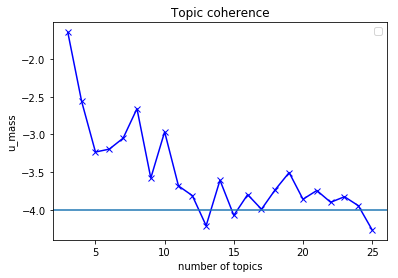

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(num_topics_list, coherenceList_umass, 'bx-')
plt.axhline(y=-4)
plt.xlabel('number of topics')
plt.ylabel('u_mass')
plt.title('Topic coherence')
plt.legend()
plt.show()

Here I get a sense that the ideal number of topics revolves around 11. I searched the best number of clusters around 11 and found that 12 is the ideal number of clusters.

In [150]:
lda_final= Lda(doc_term_matrix, num_topics=12,id2word = dictionary, passes=20,chunksize=4000,random_state=43)

INFO : using symmetric alpha at 0.08333333333333333
INFO : using symmetric eta at 0.08333333333333333
INFO : using serial LDA version on this node
INFO : running online LDA training, 12 topics, 20 passes over the supplied corpus of 12537 documents, updating every 60000 documents, evaluating every ~12537 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 15 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process e

INFO : topic #8 (0.083): 0.027*"r" + 0.026*"python" + 0.023*"sql" + 0.017*"hadoop" + 0.016*"hive" + 0.016*"tableau" + 0.012*"java" + 0.012*"technical" + 0.012*"spark" + 0.010*"pig"
INFO : topic #4 (0.083): 0.021*"sql" + 0.019*"r" + 0.019*"python" + 0.011*"technical" + 0.010*"matlab" + 0.009*"tableau" + 0.009*"data" + 0.008*"java" + 0.008*"excel" + 0.008*"c++"
INFO : topic #6 (0.083): 0.025*"python" + 0.025*"r" + 0.020*"sql" + 0.012*"tableau" + 0.012*"technical" + 0.012*"sas" + 0.011*"pandas" + 0.011*"mysql" + 0.010*"hadoop" + 0.009*"matlab"
INFO : topic diff=0.291399, rho=0.403756
DEBUG : bound: at document #0
INFO : -8.914 per-word bound, 482.4 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #

INFO : PROGRESS: pass 6, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 6, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 6, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 6, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 534/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3894/4000 documents conver

DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537 documents
DEBUG : 527/537 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3921/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : 3934/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 3936/4000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
INFO : topic #4 (0.083): 0.012*"sql" + 0.011*"r" + 0.010*"python" + 0.007*"data" + 0.006*"technical" + 0.006*"matlab" + 0.006*"excel" + 0.006*"c++" + 0.005*"computer" + 0.005*"spss"
INFO : topic #5 (0.083): 0.007*"sql" + 0.006

DEBUG : getting a new job
DEBUG : 3952/4000 documents converged within 50 iterations
DEBUG : result put
DEBUG : processed chunk, queuing the result
DEBUG : updating topics
DEBUG : getting a new job
INFO : topic #3 (0.083): 0.006*"unix" + 0.006*"technical" + 0.005*"skills" + 0.003*"linux" + 0.002*"salesforce" + 0.002*"sql" + 0.002*"powerpoint" + 0.002*"taleo" + 0.002*"project" + 0.002*"software"
INFO : topic #1 (0.083): 0.012*"python" + 0.012*"technical" + 0.011*"java" + 0.009*"sql" + 0.008*"c" + 0.008*"r" + 0.006*"c++" + 0.006*"ms" + 0.005*"windows" + 0.005*"mysql"
INFO : topic #0 (0.083): 0.009*"sql" + 0.009*"oracle" + 0.007*"technical" + 0.006*"html" + 0.006*"xml" + 0.006*"java" + 0.005*"pl" + 0.005*"windows" + 0.005*"javascript" + 0.005*"agile"
INFO : topic #11 (0.083): 0.047*"r" + 0.043*"python" + 0.042*"sql" + 0.032*"sas" + 0.026*"matlab" + 0.023*"excel" + 0.021*"c++" + 0.021*"tableau" + 0.016*"java" + 0.016*"technical"
INFO : topic #9 (0.083): 0.028*"html" + 0.027*"javascript" + 

INFO : topic #1 (0.083): 0.011*"technical" + 0.010*"python" + 0.009*"java" + 0.008*"sql" + 0.007*"c" + 0.006*"r" + 0.006*"ms" + 0.005*"c++" + 0.005*"data" + 0.005*"windows"
INFO : topic #3 (0.083): 0.006*"unix" + 0.006*"technical" + 0.005*"skills" + 0.003*"linux" + 0.003*"salesforce" + 0.003*"taleo" + 0.002*"project" + 0.002*"powerpoint" + 0.002*"powershell" + 0.002*"software"
INFO : topic #10 (0.083): 0.011*"english" + 0.005*"data" + 0.004*"indesign" + 0.004*"research" + 0.004*"excel" + 0.004*"mandarin" + 0.004*"spanish" + 0.003*"illustrator" + 0.003*"relevant" + 0.003*"photoshop"
INFO : topic diff=0.026397, rho=0.228610
DEBUG : bound: at document #0
INFO : -8.701 per-word bound, 416.0 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 16, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 16, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pas

INFO : topic diff=0.018992, rho=0.212553
DEBUG : bound: at document #0
INFO : -8.691 per-word bound, 413.3 perplexity estimate based on a held-out corpus of 537 documents with 6909 words
INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #4000/12537, outstanding queue size 1
INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #8000/12537, outstanding queue size 2
INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #12000/12537, outstanding queue size 3
INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #12537/12537, outstanding queue size 4
DEBUG : processing chunk #0 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #1 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #2 of 4000 documents
DEBUG : performing inference on a chunk of 4000 documents
DEBUG : processing chunk #3 of 537 documents
DEBUG : performing inference on a chunk of 537

In [151]:
def print_topics(model):
    data = model.top_topics(doc_term_matrix,dictionary=dictionary,topn=20)
    finaltopic_repr = []
    for topic in range(len(data)):
        wordstr =''
        for words in data[topic][0]:
            wordstr+='+'+str(words[1])
        score = data[topic][1]
        wordstr=wordstr.split('+',1)[1]
        finaltopic_repr.append((wordstr,score))
    finaltopic_repr = sorted(finaltopic_repr,key =lambda x: x[1], reverse=True)
    return finaltopic_repr

In [152]:
display(pd.DataFrame(print_topics(lda_final),columns=['Topic-word Representation','Coherence score']).sort_values(by='Coherence score',ascending=False))

DEBUG : Setting topics to those of the model: LdaModel(num_terms=25488, num_topics=12, decay=0.5, chunksize=4000)
INFO : CorpusAccumulator accumulated stats from 1000 documents
INFO : CorpusAccumulator accumulated stats from 2000 documents
INFO : CorpusAccumulator accumulated stats from 3000 documents
INFO : CorpusAccumulator accumulated stats from 4000 documents
INFO : CorpusAccumulator accumulated stats from 5000 documents
INFO : CorpusAccumulator accumulated stats from 6000 documents
INFO : CorpusAccumulator accumulated stats from 7000 documents
INFO : CorpusAccumulator accumulated stats from 8000 documents
INFO : CorpusAccumulator accumulated stats from 9000 documents
INFO : CorpusAccumulator accumulated stats from 10000 documents
INFO : CorpusAccumulator accumulated stats from 11000 documents
INFO : CorpusAccumulator accumulated stats from 12000 documents


,Topic-word Representation,Coherence score
0,hive+hadoop+python+sql+r+pig+spark+tableau+tec...,-1.473616
1,html+javascript+java+c+python+css+c+++sql+mysq...,-1.507970
2,python+r+sql+pandas+numpy+technical+scikit+tab...,-1.861966
3,r+python+sql+sas+matlab+excel+tableau+c+++java...,-1.923961
4,oracle+sql+xml+technical+pl+html+uml+agile+win...,-2.034309
5,technical+java+python+sql+c+ms+r+data+windows+...,-2.099782
6,data+sql+r+technical+excel+computer+python+mat...,-3.137381
7,data+c+++project+analytics+core+computer+analy...,-3.722686
8,sql+technical+key+oracle+k+access+means+terada...,-5.933414
9,technical+unix+skills+taleo+salesforce+powersh...,-7.028471


In [158]:
vis = pyLDAvis.gensim.prepare(lda_final, doc_term_matrix, dictionary)
vis

DEBUG : performing inference on a chunk of 12537 documents
DEBUG : 12402/12537 documents converged within 50 iterations


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     21.018930        1       1  0.178386 -0.099050
6      20.327831        1       2  0.204531 -0.141215
8      17.509239        1       3  0.230711  0.043406
9      14.393434        1       4  0.171886  0.107890
0       7.235928        1       5  0.028248  0.179300
1       3.748013        1       6 -0.012753  0.027564
4       3.368896        1       7 -0.074784 -0.057546
7       3.048049        1       8 -0.158089 -0.021893
3       2.673363        1       9 -0.151100  0.037611
2       2.334901        1      10 -0.122807 -0.011622
5       2.191694        1      11 -0.132711 -0.022145
10      2.149720        1      12 -0.161517 -0.042300, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
81    Default  1530.000000           sas  1530.000000  30.0000  30.0000
99    Default   701.000000        pandas   701.000000  29.0000  29.0000
21    Default  1020.000000    javascript  1020.000000  28.0000  28.0000
75    Default  1058.000000          hive  1058.000000  27.0000  27.0000
2     Default  1114.000000          html  1114.000000  26.0000  26.0000
0     Default   656.000000           css   656.000000  25.0000  25.0000
150   Default   567.000000         numpy   567.000000  24.0000  24.0000
100   Default   458.000000        scikit   458.000000  23.0000  23.0000
204   Default   646.000000           pig   646.000000  22.0000  22.0000
7     Default  3289.000000             r  3289.000000  21.0000  21.0000
6     Default  3500.000000        python  3500.000000  20.0000  20.0000
27    Default  1092.000000         excel  1092.000000  19.0000  19.0000
31    Default  1462.000000        matlab  1462.000000  18.0000  18.0000
20    Default  1851.000000          java  1851.000000  17.0000  17.0000
139   Default   396.000000           php   396.000000  16.0000  16.0000
39    Default   357.000000         hbase   357.000000  15.0000  15.0000
252   Default   300.000000    matplotlib   300.000000  14.0000  14.0000
82    Default   954.000000         spark   954.000000  13.0000  13.0000
47    Default   515.000000    powerpoint   515.000000  12.0000  12.0000
898   Default   286.000000         sqoop   286.000000  11.0000  11.0000
13    Default  1582.000000             c  1582.000000  10.0000  10.0000
259   Default   359.000000         scipy   359.000000   9.0000   9.0000
195   Default   684.000000          spss   684.000000   8.0000   8.0000
253   Default   302.000000         learn   302.000000   7.0000   7.0000
216   Default   513.000000           xml   513.000000   6.0000   6.0000
78    Default   337.000000    regression   337.000000   5.0000   5.0000
269   Default   257.000000        jquery   257.000000   4.0000   4.0000
38    Default  1346.000000        hadoop  1346.000000   3.0000   3.0000
93    Default   369.000000           svm   369.000000   2.0000   2.0000
107   Default   357.000000    clustering   357.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1761  Topic12     2.487796    pythonandr     5.259302   3.0912  -7.1816
8791  Topic12     1.941203    googledocs     3.634740   3.2126  -7.4297
4203  Topic12     3.911214  teambuilding    11.493258   2.7619  -6.7292
363   Topic12    15.235598      research   110.809265   1.8557  -5.3694
6281  Topic12     2.556130      japanese     5.950209   2.9949  -7.1545
9906  Topic12     2.518835       andspss     6.134675   2.9497  -7.1692
9839  Topic12     1.986018   educational     4.108534   3.1129  -7.4069
911   Topic12    10.816319     photoshop    86.930382   1.7558  -5.7119
49    Topic12    11.414258      relevant   105.017982   1.6206  -5.6581
690   Topic12     7.987966    leadership    71.688324   1.6454  -6.0151
2370  Topic12     5.593969     strategic    41.661980   1.8319  -6.3713
714   Topic12    10.353340      b

In [178]:
doc2topic =lda_final.get_document_topics(doc_term_matrix,minimum_probability=0)
doc2topic = pd.DataFrame(list(doc2topic))
for i in doc2topic.columns:
    doc2topic.iloc[:,i]=doc2topic.iloc[:,i].apply(lambda x: x[1])

In [179]:
doc2topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.006410,0.006410,0.006410,0.006410,0.006410,0.006410,0.736292,0.006410,0.006410,0.199605,0.006410,0.006411
1,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.956348,0.003968,0.003968
2,0.005208,0.005208,0.005208,0.005208,0.005208,0.005208,0.005209,0.005208,0.005208,0.005209,0.005208,0.942707
3,0.002604,0.042107,0.002604,0.002604,0.002604,0.002604,0.002604,0.002604,0.200868,0.245110,0.002604,0.491081
4,0.004902,0.412771,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.205120,0.337991


In [180]:
data = pd.read_csv('./data_clean_1.csv')
data_final =pd.concat([data,doc2topic],axis=1)
data_final.head()

,additional_info,rb,name,id,summary_title,location,current_job_company,current_job_title,current_job_desc,current_job_duration,...,2,3,4,5,6,7,8,9,10,11
0,"['TECHNICAL SKILLS\xa0', <br/>, '\xa0', <br/>,...",NaN,Tracy-Ruan,c47f7ac095973653?sp=0,Data Scientist Intern,"San Francisco, CA",NaN,Data Scientist Intern,['• Prepared customer behavior datasets for cl...,August 2017 to November 2017,...,0.006410,0.006410,0.006410,0.006410,0.736292,0.006410,0.006410,0.199605,0.006410,0.006411
1,"['TECHNICAL SKILLS:\xa0', <br/>, 'Languages ...",NaN,Sai-Nadimpalli,19e0d35744cc56a6?sp=0,Junior Data Scientist,"Kansas City, MO",['Sprint Corporation'],Junior Data Scientist,['• Developed a Hybrid Recommendation System f...,May 2017 to August 2017,...,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.003968,0.956348,0.003968,0.003968
2,"['TECHNICAL SKILLS\xa0', <br/>, '• Proficien...",NaN,Nick-Shi,accfd33784428f69?sp=0,Data Scientist Intern,"Malibu, CA",['MarketPsych Data'],Data Scientist Intern,['• Manipulated and interpreted insights fro...,February 2018 to Present,...,0.005208,0.005208,0.005208,0.005208,0.005209,0.005208,0.005208,0.005209,0.005208,0.942707
3,"['TECHNICAL SKILLS\xa0', <br/>, 'Relevant Cour...",NaN,Harsh-Mehta,2a4af24d87cca9cd?sp=0,Data Scientist,"Bloomington, IN",['Indiana University'],Data Scientist,['• Implemented probabilistic character recogn...,November 2017 to November 2017,...,0.002604,0.002604,0.002604,0.002604,0.002604,0.002604,0.200868,0.245110,0.002604,0.491081
4,"['SKILLS\xa0', <br/>, '\xa0', <br/>, 'SOFTWARE...",NaN,Daniel-Wu,246fa163d0b35d5b?sp=0,DATA SCIENTIST,"Brooklyn, NY",['MAPSCorps'],DATA SCIENTIST,['Acted as a Chinese translator when collectin...,July 2016 to August 2016,...,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.205120,0.337991


In [202]:
data_final[data_final['current_job_title']=='Data Scientist'].iloc[:,30:]

,prev_job_duration_months,total_exp_durations_months,work_authp,prev_job_desc_clean,prev_job_title_cats,0,1,2,3,4,5,6,7,8,9,10,11
3,0,1,1.0,"['performed', 'analysis', 'supermarket', 'data...",Data Analyst,0.002604,0.042107,0.002604,0.002604,0.002604,0.002604,0.002604,0.002604,0.200868,0.245110,0.002604,0.491081
5,0,2,1.0,['nan'],Others,0.016667,0.483999,0.016667,0.349333,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667
6,1,8,1.0,"['wrote', 'sql', 'query', 'get', 'age', 'inves...",Data Analyst,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
7,1,8,1.0,"['wrote', 'sql', 'query', 'get', 'age', 'inves...",Data Analyst,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
8,0,8,1.0,['nan'],Others,0.003623,0.003623,0.003623,0.003623,0.003623,0.003623,0.960144,0.003623,0.003623,0.003623,0.003623,0.003623
9,2,7,0.0,"['bring', 'stream', 'social', 'medium', 'data'...",Student,0.003968,0.003968,0.003968,0.003968,0.066436,0.003968,0.893881,0.003968,0.003968,0.003968,0.003968,0.003968
11,0,-6,NaN,"['may', '2018xa0', 'br', 'performed', 'data', ...",Others,0.004386,0.134579,0.004386,0.004386,0.004386,0.004386,0.004386,0.004386,0.501491,0.324456,0.004386,0.004386
12,0,7,NaN,['nan'],Others,0.005208,0.005208,0.005208,0.005208,0.005208,0.005208,0.785260,0.005208,0.005208,0.005208,0.005208,0.162656
19,-4,6,NaN,"['built', 'simple', 'classifier', 'classified'...",Project Manager,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.007576,0.916665
35,3,10,1.0,"['built', 'cleaned', 'managed', 'database', 'c...",Student,0.041667,0.541667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667


In [186]:
vis.topic_info.to_csv('12topic_wordDist.csv')

In [187]:
data_final.to_csv('data_post_LDA')

In [ ]:
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')